In [1]:
import pickle

from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from nanoepitools.reference_cpgs import ReferenceCpGs

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from benchmark_pycometh.config import module_config
from benchmark_pycometh.diffmet.asm_results import Results

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged_2_rewritten.m5"
results_cache_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/all_results_cache.pkl"
load_from_cache=True

In [ ]:
def get_result_file(caller, segmentation=None, test=None, ihw=False, segments_per_window=None, window_size=None):
    simdir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/")
    if caller == "gt":
        return simdir.joinpath("wgbs/merged/changepoints.txt")
    simdir = simdir.joinpath(segmentation)
    if caller == "methcp":
        return simdir.joinpath("methcp_dmr_2.bed")
    ihw = f"ihw_{'yes' if ihw else 'no'}"
    if segmentation == "pycometh":
        simfile = f"diffmet_{window_size}_{segments_per_window}_hyp_{test}_{ihw}.tsv"
        return simdir.joinpath("diffmet", simfile)
    if caller == "pycometh":
        return simdir.joinpath(f"pycometh_methcomp/diffmet/diffmet_hyp_{test}_{ihw}.tsv ")

def get_all_result_files():
    yield {"key":"GT", "file":get_result_file("gt"), "caller": "gt"}
    yield {"key":"MethCP", "file":get_result_file("methcp", "methcp"), "caller": "methcp"}
    for label, segmentation in  ("PycoMeth", "pycometh"), ("PycoMeth (MethylKit)", "methylkit"), ("PycoMeth (MethCP)", "methcp"):
        for ihw in True, False:
            for test_label, test in ("BS Diff", "bs_diff"), ("LLR-Diff", "llr_diff"), ("Fisher-E","count_dependency"):
                name = f"{label} {test_label}{' (IHW)' if ihw else ''}"
                if segmentation == "pycometh":
                    yield {"key": name + " coarse", "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 8, 300)}
                    yield {"key": name + " coarser", "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 8, 600)}
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 16, 300)}
                else:
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw)}

if load_from_cache:
    with open(results_cache_file, "rb") as f:
        results = pickle.load(f)
else:
    results = Results(results_cache_file, simulated_m5)

for res_config in get_all_result_files():
    if res_config["key"] not in results.segments:
        results.load_segments(**res_config)

with open(results_cache_file, "bw") as f:
    pickle.dump(results, f)

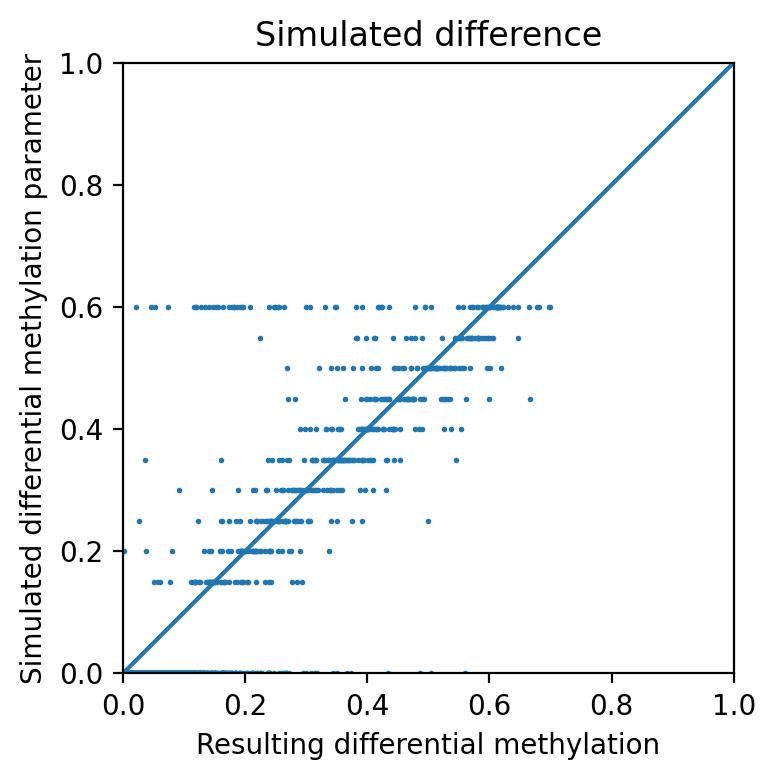

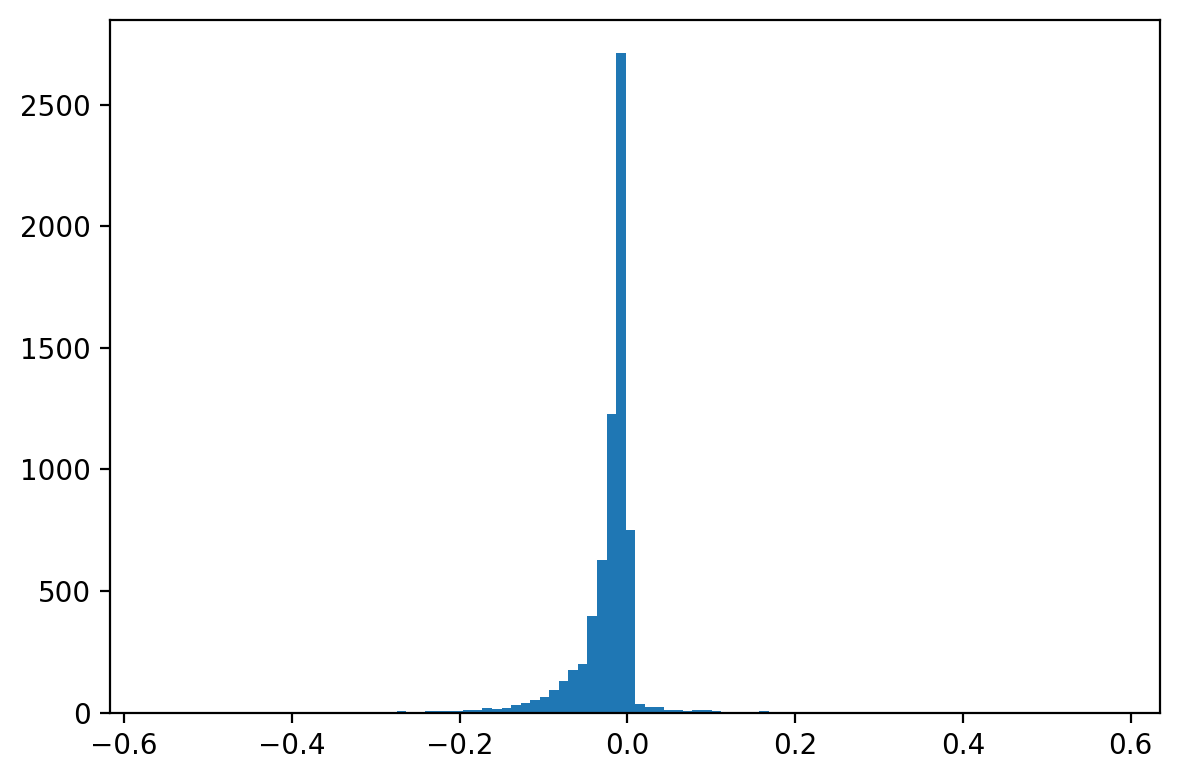

In [5]:
pa.figure()
plt.title("Simulated difference")
plt.scatter(results.segments["GT"]["diffmet"], np.abs(results.segments["GT"]["theta"]), s=1)
plt.xlabel("Resulting differential methylation")
plt.ylabel("Simulated differential methylation parameter")
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")
pa.saveandshow("simulated_difference_vs_parameters")

pa.figure()
plt.hist(np.abs(results.segments["GT"]["theta"]) - results.segments["GT"]["diffmet"], bins=100)
plt.show()

In [6]:

class ResultComparer:
    def __init__(self, segments):
        self.segments = {k:v.copy() for k,v in segments.items()}

    def remove_cpgs_not_in_gt(self, gt_key):
        """
        Removing a small number of CpGs that fell through the cracks
        as they are in between block sin the simulation
        """
        allowed_cgs = unions(self.segments[gt_key]["CpGs"])
        for key in self.segments:
            if key == gt_key:
                continue
            self.segments[key]["CpGs"] = self.segments[key]["CpGs"].map(lambda cpgs: cpgs.intersection(allowed_cgs))

    def get(self, key, diffmet_threshold=0.1, below_threshold=False, theta_threshold=0, pval_threshold = 1):
        ret = self.segments[key]

        idx = ret["diffmet"].map(lambda x: abs(x)>=diffmet_threshold)
        if theta_threshold != 0:
            idx = idx & ret["theta"].map(lambda x: abs(x) >= theta_threshold)

        if below_threshold:
            idx = ~idx

        if pval_threshold < 1:
            idx = idx & (ret["adj_pvalue"] < pval_threshold)

        return ret.loc[idx]

    def compute_tpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_gt_pos = len(gt_pos_cgs)
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        if num_gt_pos == 0:
            return np.nan
        return num_true_pos / num_gt_pos

    def compute_precision(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pred = len(pred_cgs)

        if num_pred == 0:
            return np.nan
        return num_true_pos / num_pred

    def compute_fpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold = 0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_gt_neg = len(gt_neg_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_gt_neg == 0:
            return np.nan
        return num_false_pos / num_gt_neg

    def compute_fdr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_pred = len(pred_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_pred == 0:
            return np.nan
        return num_false_pos / num_pred

    def compute_discovery_counts(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1, pval_threshold=0.05):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold, pval_threshold=pval_threshold)
        pred_cgs = unions(pred["CpGs"])

        gt_neg = self.get(gt, diffmet_threshold=0, below_threshold=True, theta_threshold=theta_threshold)
        gt_pos = self.get(gt, diffmet_threshold=0, theta_threshold=theta_threshold)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        return num_false_pos, num_true_pos

In [7]:

def plot_roc(gt, title="", figurename=None, tool_colors=None):
    if tool_colors is None:
        tool_colors = {k:v for k,v in results.colors.items() if k != "GT"}

    ps = np.arange(0.001, 0.5, 0.1)
    recall = {t:[] for t in tool_colors}
    precision = {t:[] for t in tool_colors}

    rc = ResultComparer(results.segments)
    rc.segments["GT"] = gt
    rc.remove_cpgs_not_in_gt("GT")

    for p in ps:
        for tool in tool_colors:
            recall[tool].append(rc.compute_tpr("GT", tool, pval_threshold=p))
            precision[tool].append(1-rc.compute_fdr("GT", tool, pval_threshold=p))
    o5_index = np.argmin(np.abs((ps-0.05)))
    print(recall, precision)
    fig, (ax1, ax2, ax3) = pa.subplots(1,3, figsize=(12,5))

    plt.suptitle(title)
    ax1.set_title("Recall")
    for tool, color in tool_colors.items():
        ax1.plot(ps,recall[tool], label=tool, c=color)

    ax2.set_title("Precision")
    for tool, color in tool_colors.items():
        ax2.plot(ps,precision[tool], label=tool, c=color)

    for tool, color in tool_colors.items():
        auc = np.nansum(recall[tool] * np.diff(precision[tool], prepend=0))
        ax3.plot(precision[tool],recall[tool], label=f"{tool} AUC={auc:.2f}", c=color)
        ax3.scatter([precision[tool][o5_index]], [recall[tool][o5_index]], c=color)
    ax3.legend()
    ax3.set_ylabel("Recall")
    ax3.set_xlabel("Precision")

    for ax in ax1, ax2, ax3:
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_aspect("equal")
    plt.tight_layout()
    pa.saveandshow(figurename)



def plot_measures(gt, title="", figurename=None, tool_colors=None, tool_patterns=None):
    if tool_colors is None:
        tool_colors = {k:v for k,v in results.colors.items() if k != "GT"}
    if tool_patterns is None:
        tool_patterns = {k:v for k,v in results.patterns.items() if k != "GT"}

    recall = []
    precision = []
    f1 = []

    rc = ResultComparer(results.segments)
    rc.segments["GT"] = gt
    rc.remove_cpgs_not_in_gt("GT")


    for tool in tool_colors:
        p = 1-rc.compute_fdr("GT", tool, pval_threshold=0.05, theta_threshold=0.1, diffmet_threshold=0.15)
        r = rc.compute_tpr("GT", tool, pval_threshold=0.05, theta_threshold=0.1, diffmet_threshold=0.15)
        f = 2*(p*r)/(p+r)

        recall.append(r)
        precision.append(p)
        f1.append(f)

    pa.figure(figsize=(16,8))
    plt.title(title)
    x = 0
    for y, (tool, color) in zip(recall, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, hatch=tool_patterns.get(tool, ""))
        x+=1

    x+=1
    for y, (tool, color) in zip(precision, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, hatch=tool_patterns.get(tool, ""))
        x+=1

    x+=1
    for y, (tool, color) in zip(f1, tool_colors.items()):
        plt.bar(x,y, width=1, color=color, label=tool, hatch=tool_patterns.get(tool, ""))
        x+=1

    xticks_locs = np.arange(len(tool_colors)/2, (len(tool_colors)+1)*3, len(tool_colors)+1)
    plt.xticks(xticks_locs, ["Recall", "Precision", "F1-score"])

    plt.legend(loc=(1.04,0))
    plt.ylim(0,1)
    plt.tight_layout()
    pa.saveandshow(figurename)

def plot_roc_over_effect_size(gt, title="", figurename=None, tool_colors=None):
    if tool_colors is None:
        tool_colors = {k:v for k,v in results.colors.items() if k != "GT"}

    rc = ResultComparer(results.segments)
    rc.segments["GT"] = gt
    rc.remove_cpgs_not_in_gt("GT")

    ess = np.arange(0.1, 1.05, 0.075)
    recall = {t:[] for t in tool_colors}
    precision = {t:[] for t in tool_colors}
    f1 = {t:[] for t in tool_colors}
    for es in ess:
        for tool in tool_colors:
            r = rc.compute_tpr("GT", tool, theta_threshold=es, pval_threshold=0.05)
            p = 1-rc.compute_fdr("GT", tool, diffmet_threshold=es, pval_threshold=0.05)
            if p+r > 0:
                f = 2*(p*r)/(p+r)
            else:
                f = np.nan
            recall[tool].append(r)
            precision[tool].append(p)
            f1[tool].append(f)

    fig, (ax1, ax2, ax3) = pa.subplots(1,3, figsize=(16, 8))
    plt.suptitle(title)
    ax1.set_title("Recall")
    for tool, color in tool_colors.items():
        ax1.plot(ess,recall[tool], label=tool, c=color)
    ax1.set_ylabel("Recall")

    ax2.set_title("Precision")
    for tool, color in tool_colors.items():
        ax2.plot(ess,precision[tool], label=tool, c=color)
        ax2.set_ylabel("Precision")

    ax3.set_title("F1-score")
    for tool, color in tool_colors.items():
        ax3.plot(ess,f1[tool], label=tool, c=color)
    ax3.set_ylabel("F1-score")
    ax3.legend()

    for ax in ax1, ax2, ax3:
        ax.set_xlim(0,1)
        ax.set_ylim(0.5,1)
        ax.set_aspect("equal")
        ax.set_xlabel("Effect size")
    pa.saveandshow(figurename)

In [8]:
results.colors = {"GT": "gray"}
for key in results.segments:
    if key == "MethCP":
        results.colors[key] = "#88498F"
    elif "(MethCP)" in key:
        results.colors[key] = "#C492B1"
    elif "(MethylKit)" in key:
        results.colors[key] = "#49C6E5"
    elif "coarser" in key:
        results.colors[key] = "#C96300"
    elif "coarse" in key:
        results.colors[key] = "#ED7400"
    else:
        results.colors[key] = "#D58936"

results.patterns = {}
for key in results.segments:
    if "LLR-Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "O"
        else:
            results.patterns[key] = "/"
    elif "BS Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "."
        else:
            results.patterns[key] = "\\"
    elif "Fisher-E" in key:
        if "IHW" in key:
            results.patterns[key] = "o"
        else:
            results.patterns[key] = "-"

In [36]:
results.colors

{'GT': '#D58936',
 'PycoMeth BS Diff (IHW) coarse': '#ED7400',
 'PycoMeth BS Diff (IHW)': '#D58936',
 'PycoMeth LLR-Diff (IHW) coarse': '#ED7400',
 'PycoMeth LLR-Diff (IHW)': '#D58936',
 'PycoMeth Fisher-E (IHW) coarse': '#ED7400',
 'PycoMeth Fisher-E (IHW)': '#D58936',
 'PycoMeth BS Diff coarse': '#ED7400',
 'PycoMeth BS Diff': '#D58936',
 'PycoMeth LLR-Diff coarse': '#ED7400',
 'PycoMeth LLR-Diff': '#D58936',
 'PycoMeth Fisher-E coarse': '#ED7400',
 'PycoMeth Fisher-E': '#D58936',
 'MethCP': '#88498F',
 'PycoMeth (MethylKit) BS Diff (IHW)': '#49C6E5',
 'PycoMeth (MethylKit) LLR-Diff (IHW)': '#49C6E5',
 'PycoMeth (MethylKit) Fisher-E (IHW)': '#49C6E5',
 'PycoMeth (MethylKit) BS Diff': '#49C6E5',
 'PycoMeth (MethylKit) LLR-Diff': '#49C6E5',
 'PycoMeth (MethylKit) Fisher-E': '#49C6E5',
 'PycoMeth (MethCP) BS Diff (IHW)': '#C492B1',
 'PycoMeth (MethCP) LLR-Diff (IHW)': '#C492B1',
 'PycoMeth (MethCP) Fisher-E (IHW)': '#C492B1',
 'PycoMeth (MethCP) BS Diff': '#C492B1',
 'PycoMeth (MethCP) 

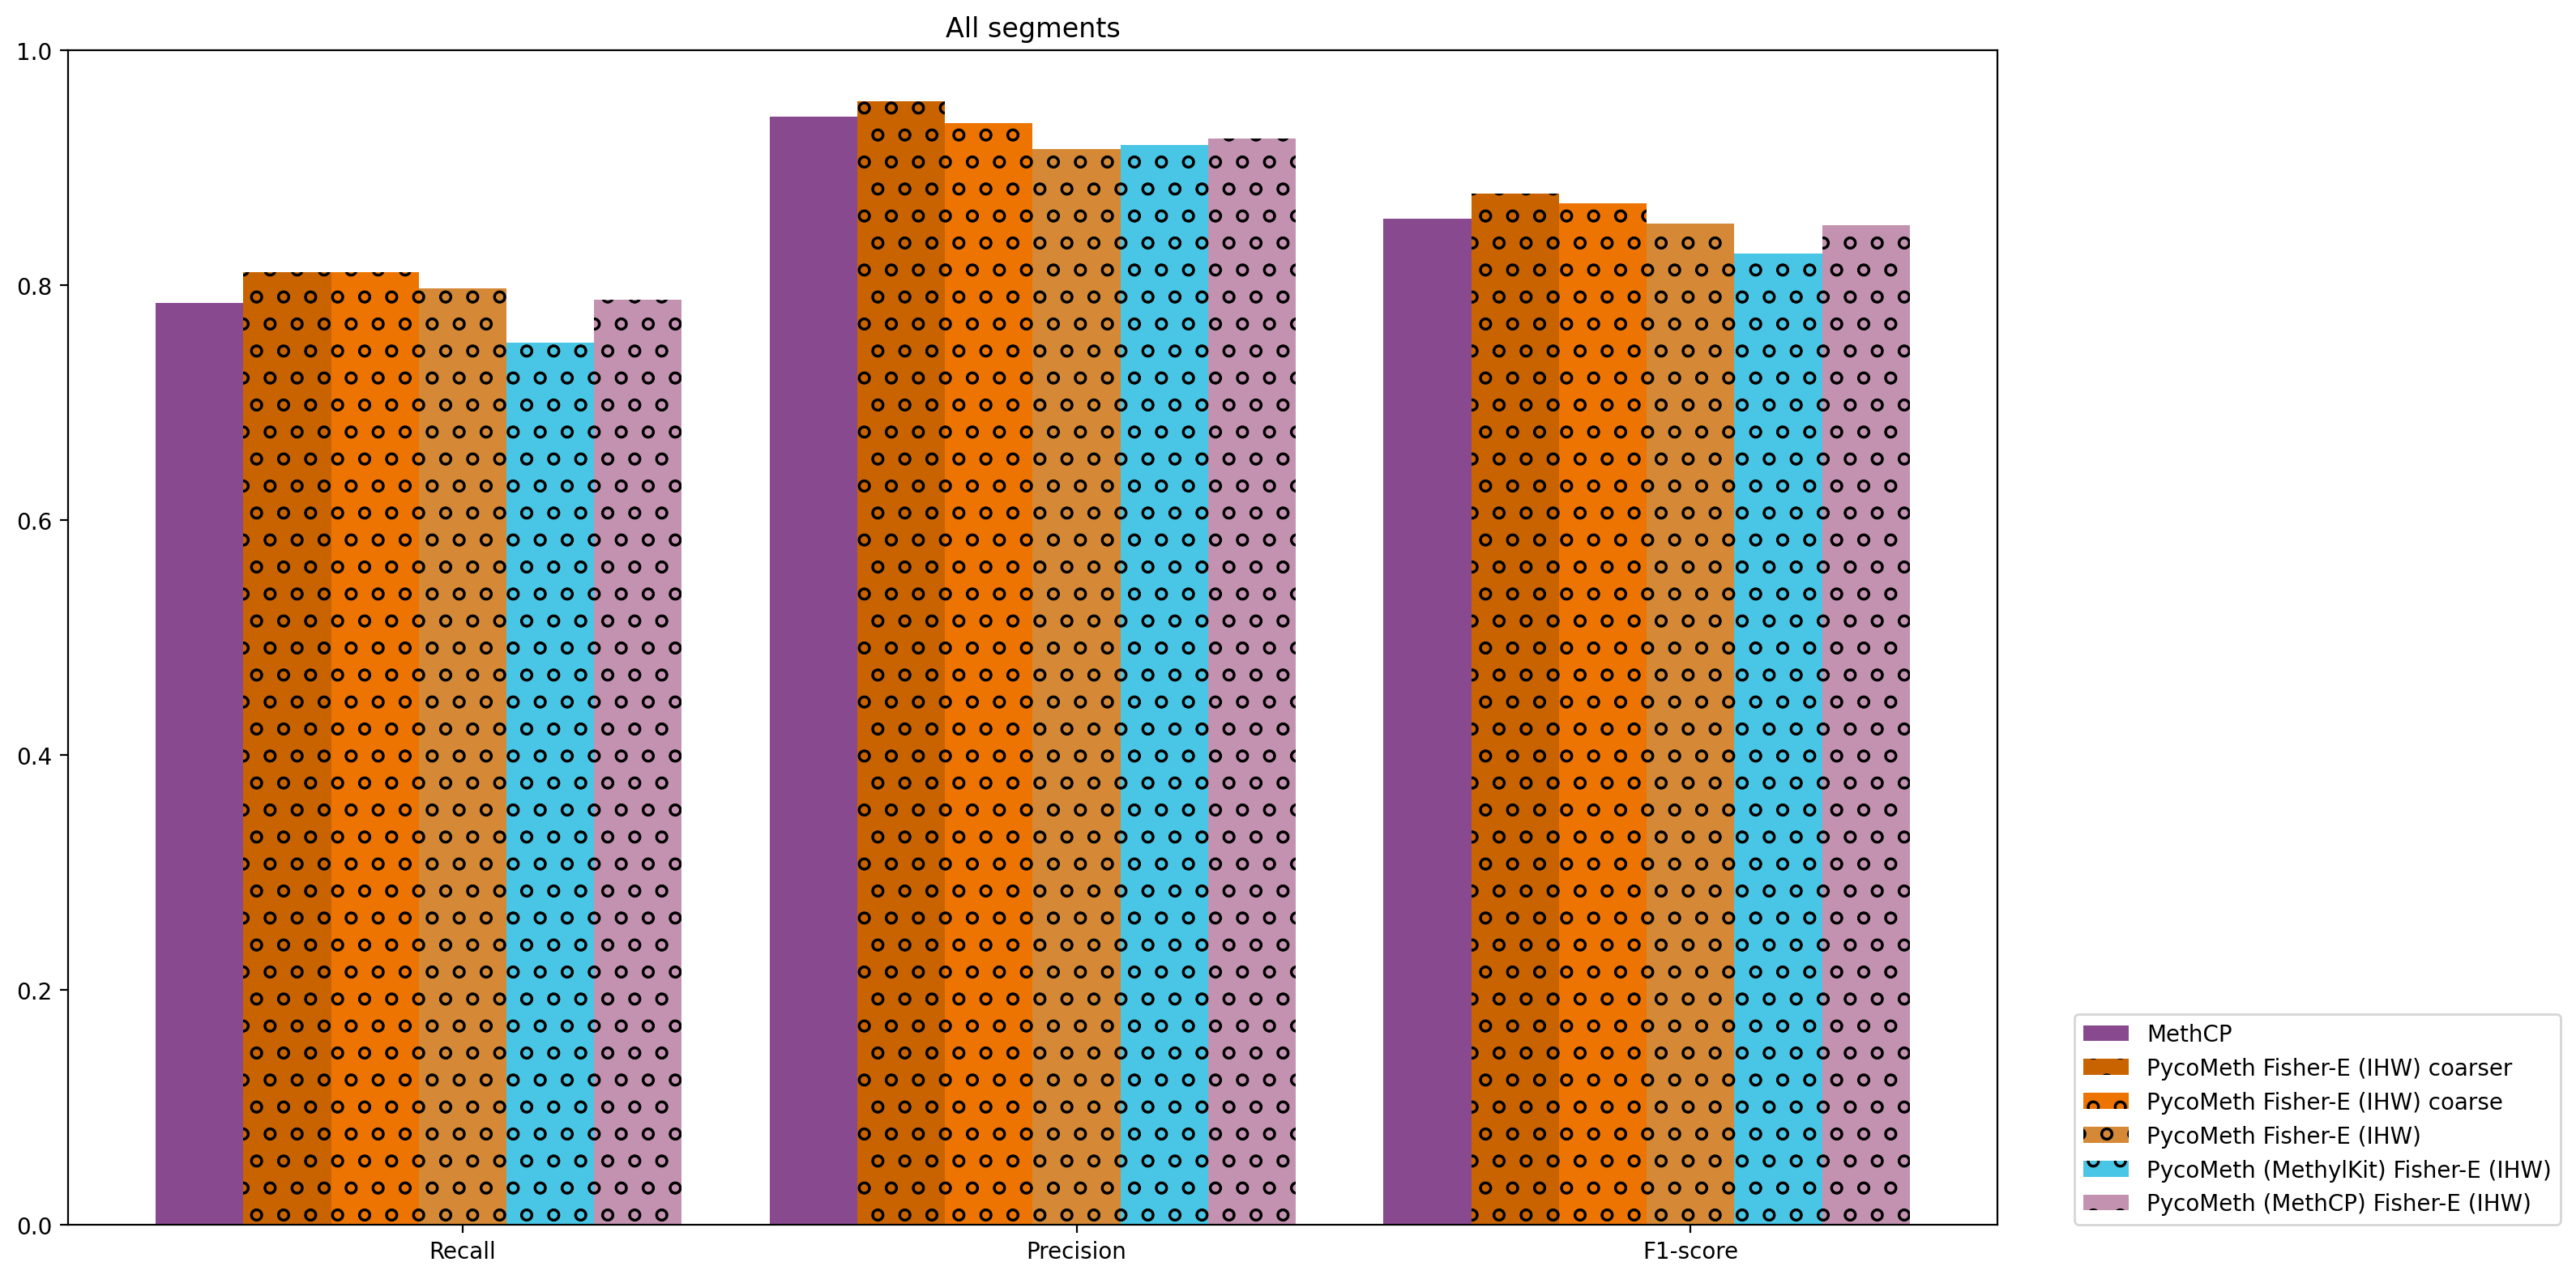

In [9]:
tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarser", "PycoMeth Fisher-E (IHW) coarse", "PycoMeth Fisher-E (IHW)", "PycoMeth (MethylKit) Fisher-E (IHW)", "PycoMeth (MethCP) Fisher-E (IHW)"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all", tool_colors=tool_colors)

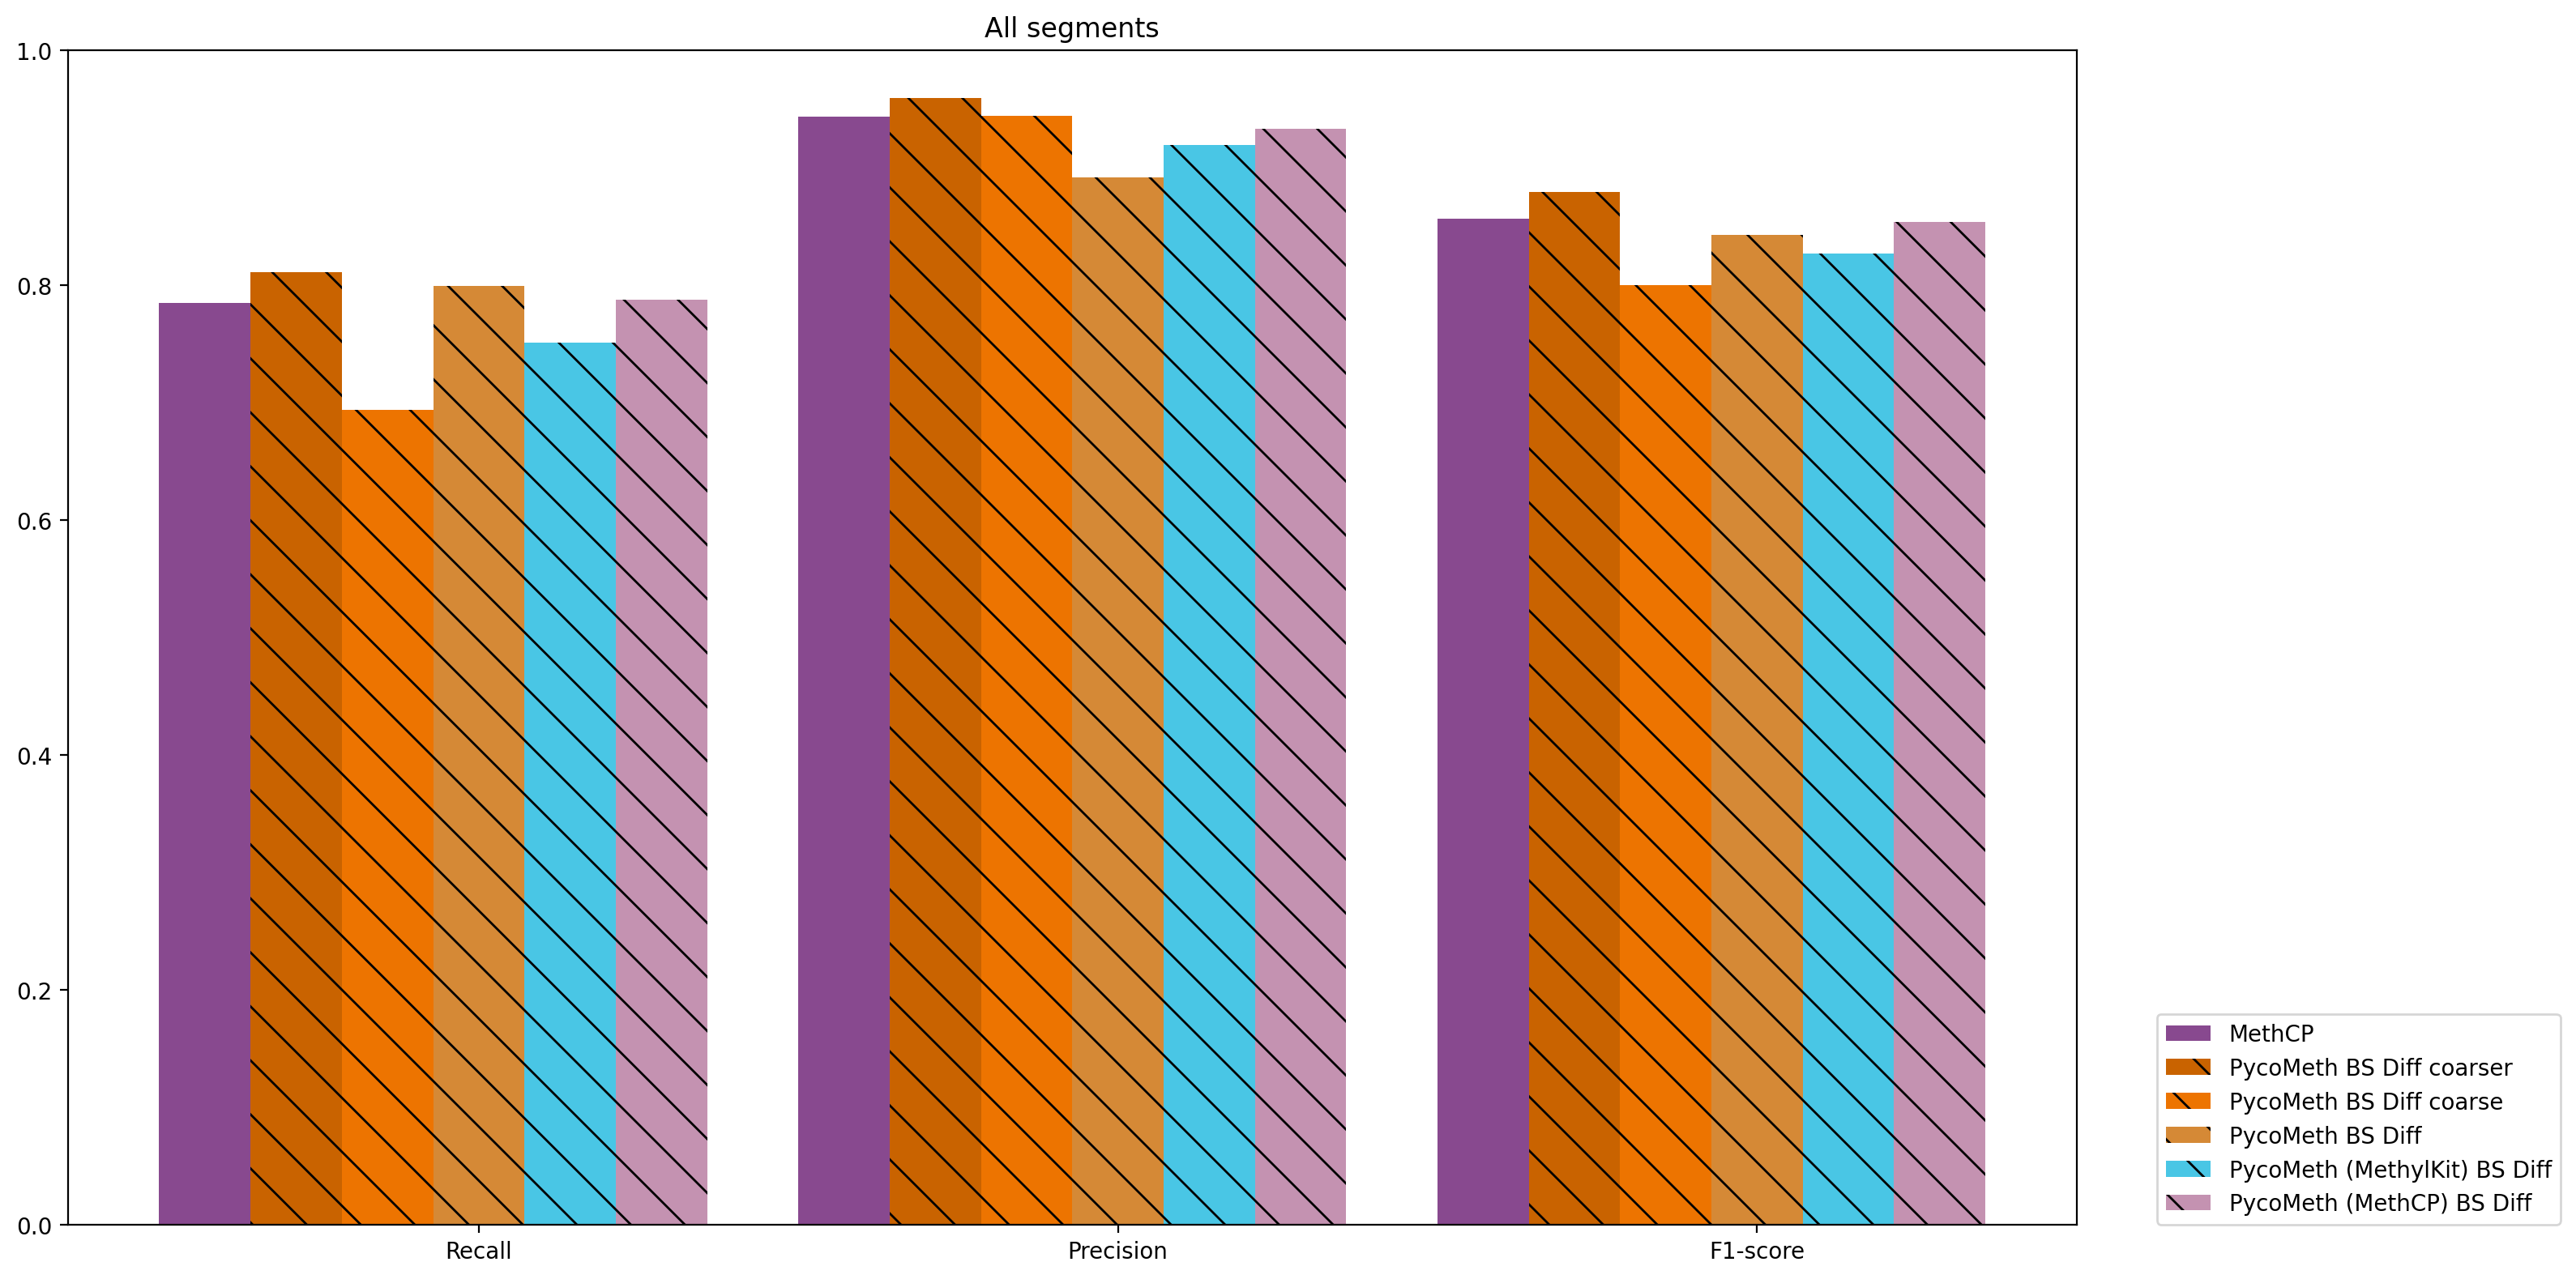

In [10]:
tools_include = ["MethCP", "PycoMeth BS Diff coarser", "PycoMeth BS Diff coarse", "PycoMeth BS Diff", "PycoMeth (MethylKit) BS Diff", "PycoMeth (MethCP) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all", tool_colors=tool_colors)

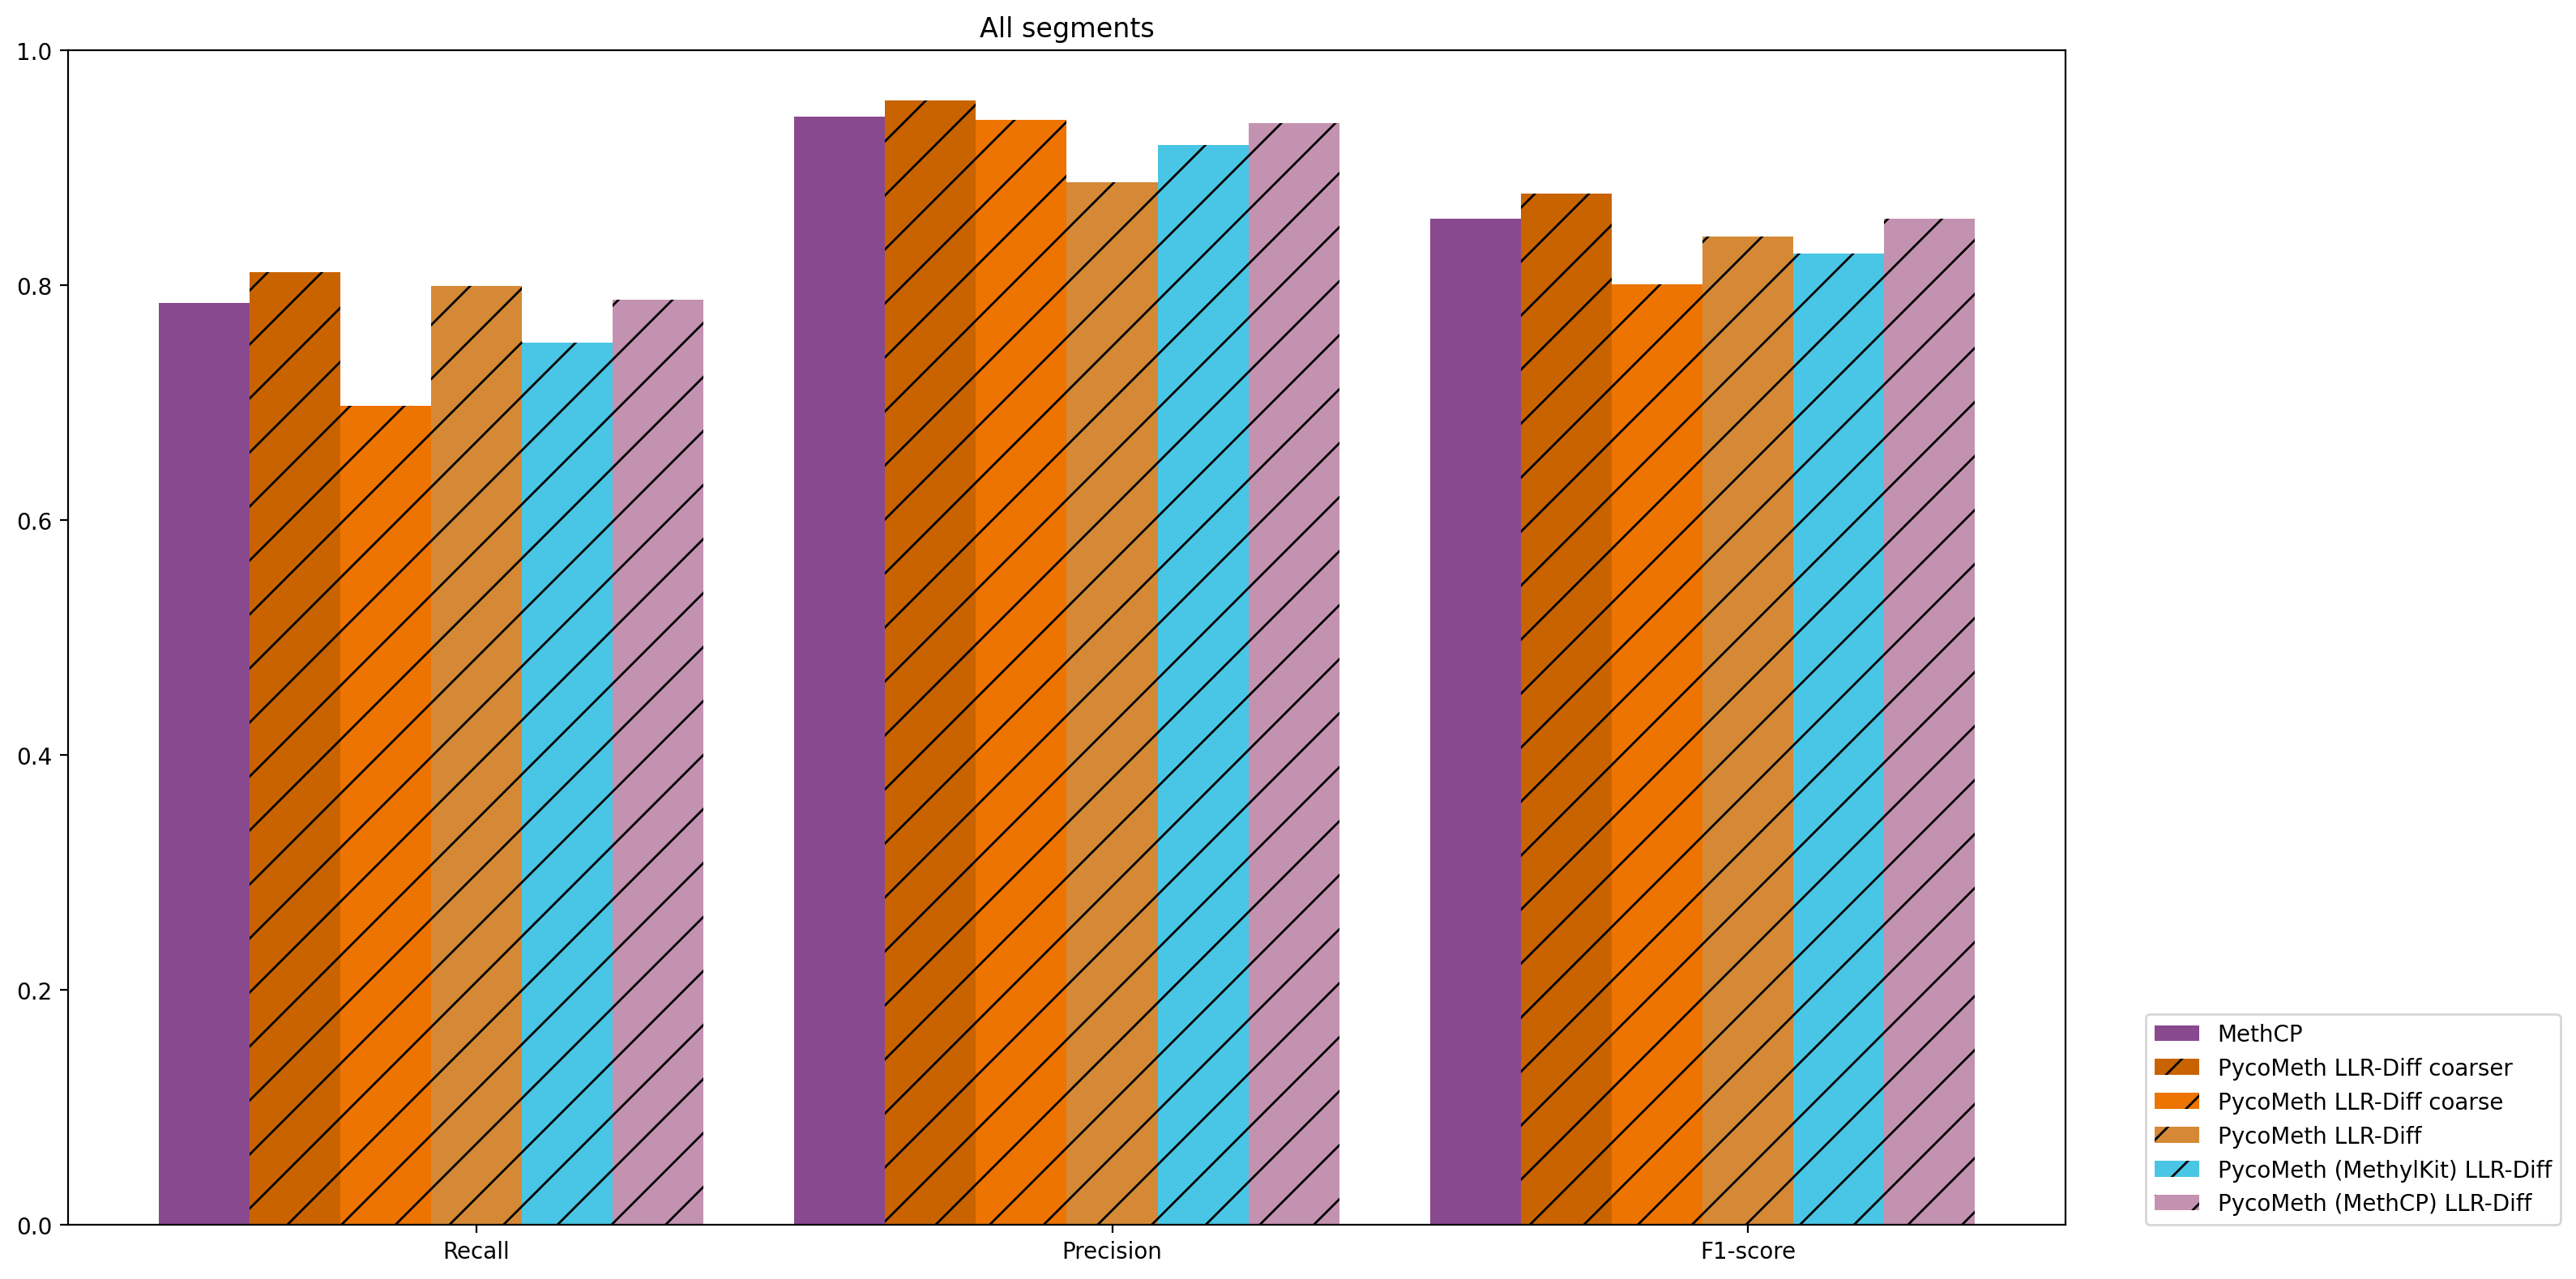

In [11]:
tools_include = ["MethCP", "PycoMeth LLR-Diff coarser", "PycoMeth LLR-Diff coarse", "PycoMeth LLR-Diff", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethCP) LLR-Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all", tool_colors=tool_colors)

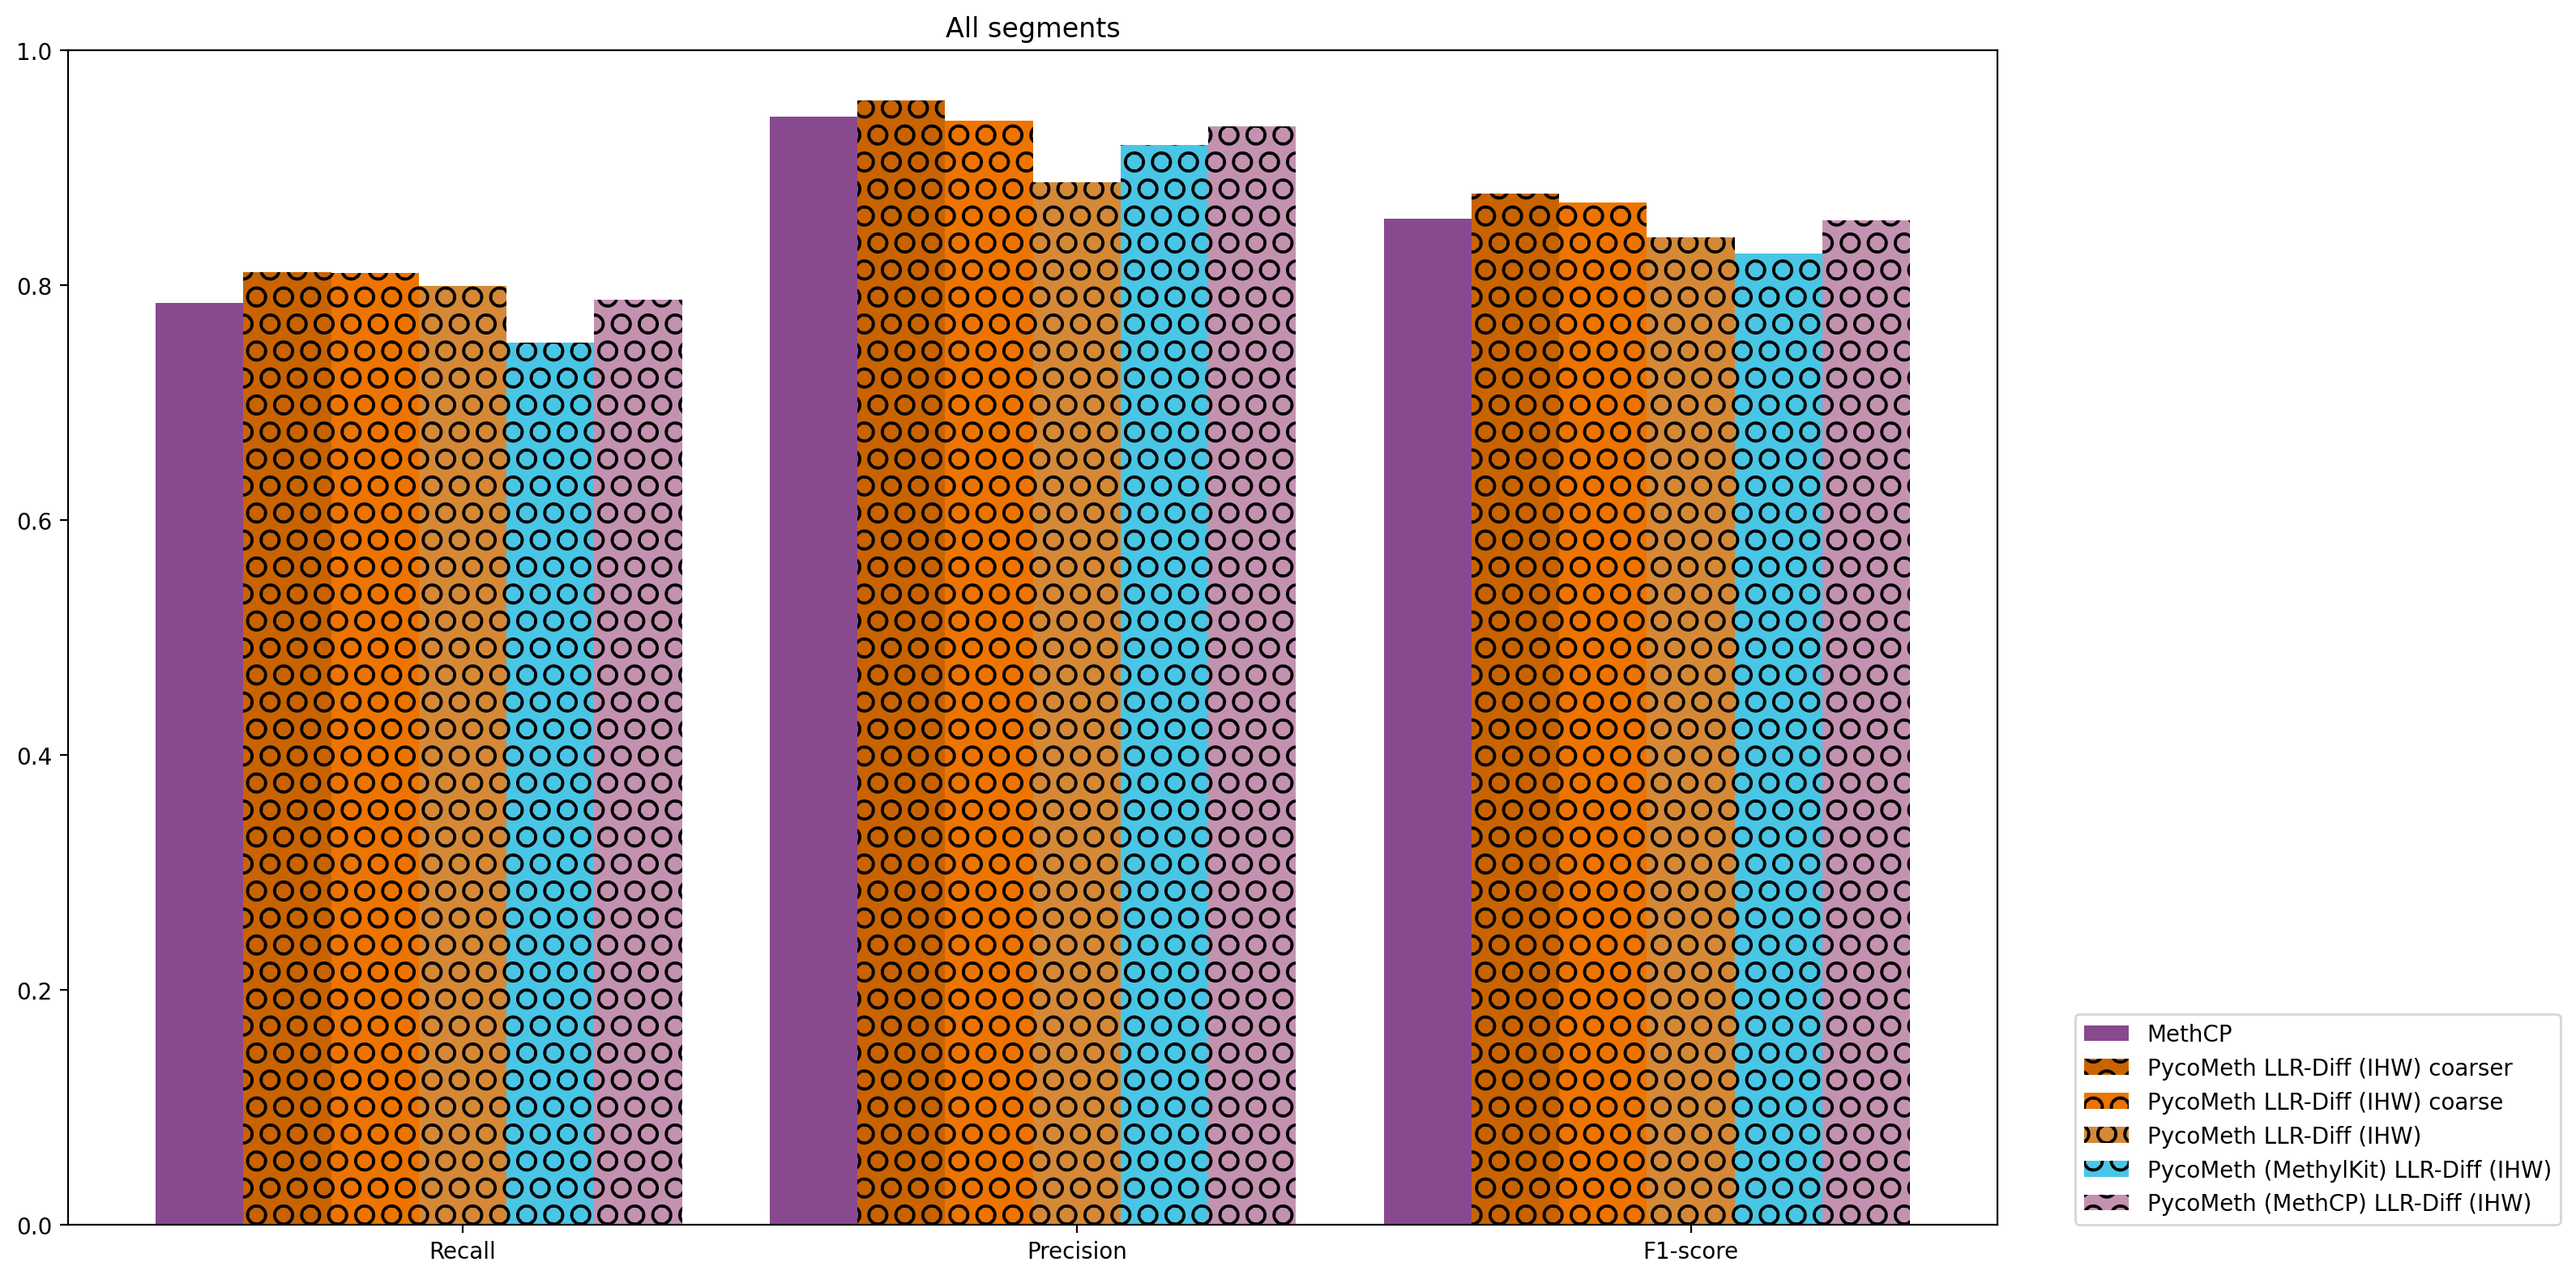

In [12]:
tools_include = ["MethCP", "PycoMeth LLR-Diff (IHW) coarser", "PycoMeth LLR-Diff (IHW) coarse", "PycoMeth LLR-Diff (IHW)", "PycoMeth (MethylKit) LLR-Diff (IHW)", "PycoMeth (MethCP) LLR-Diff (IHW)"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all", tool_colors=tool_colors)

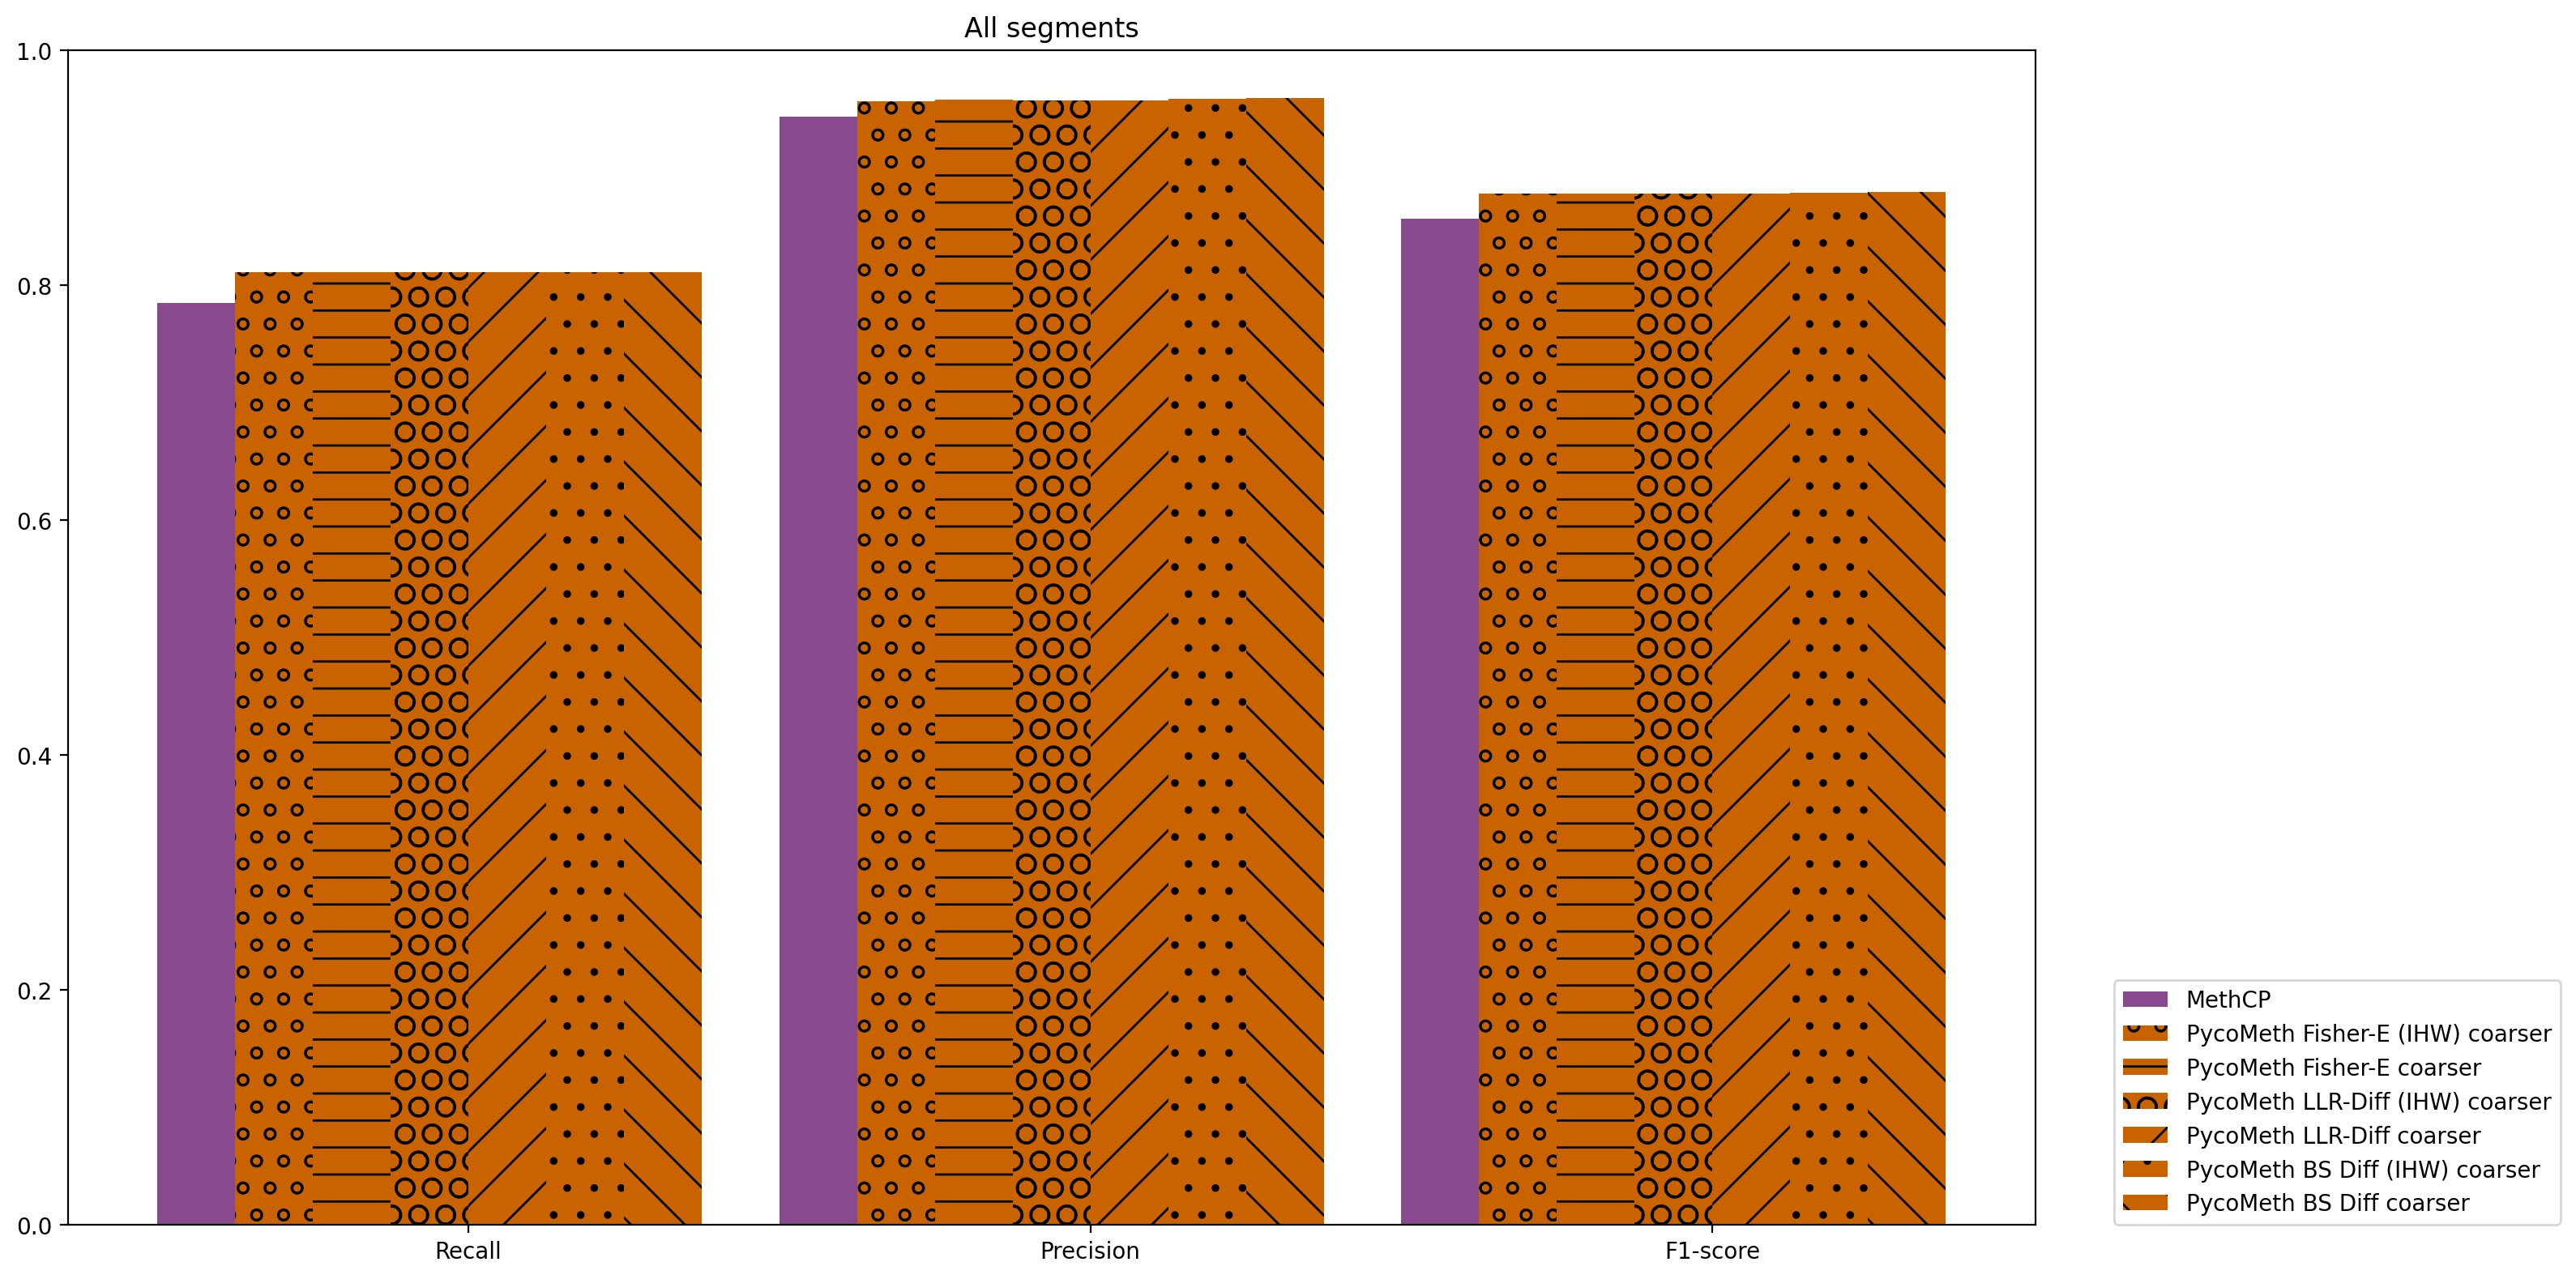

In [14]:
tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarser", "PycoMeth Fisher-E coarser", "PycoMeth LLR-Diff (IHW) coarser", "PycoMeth LLR-Diff coarser", "PycoMeth BS Diff (IHW) coarser", "PycoMeth BS Diff coarser"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all", tool_colors=tool_colors)

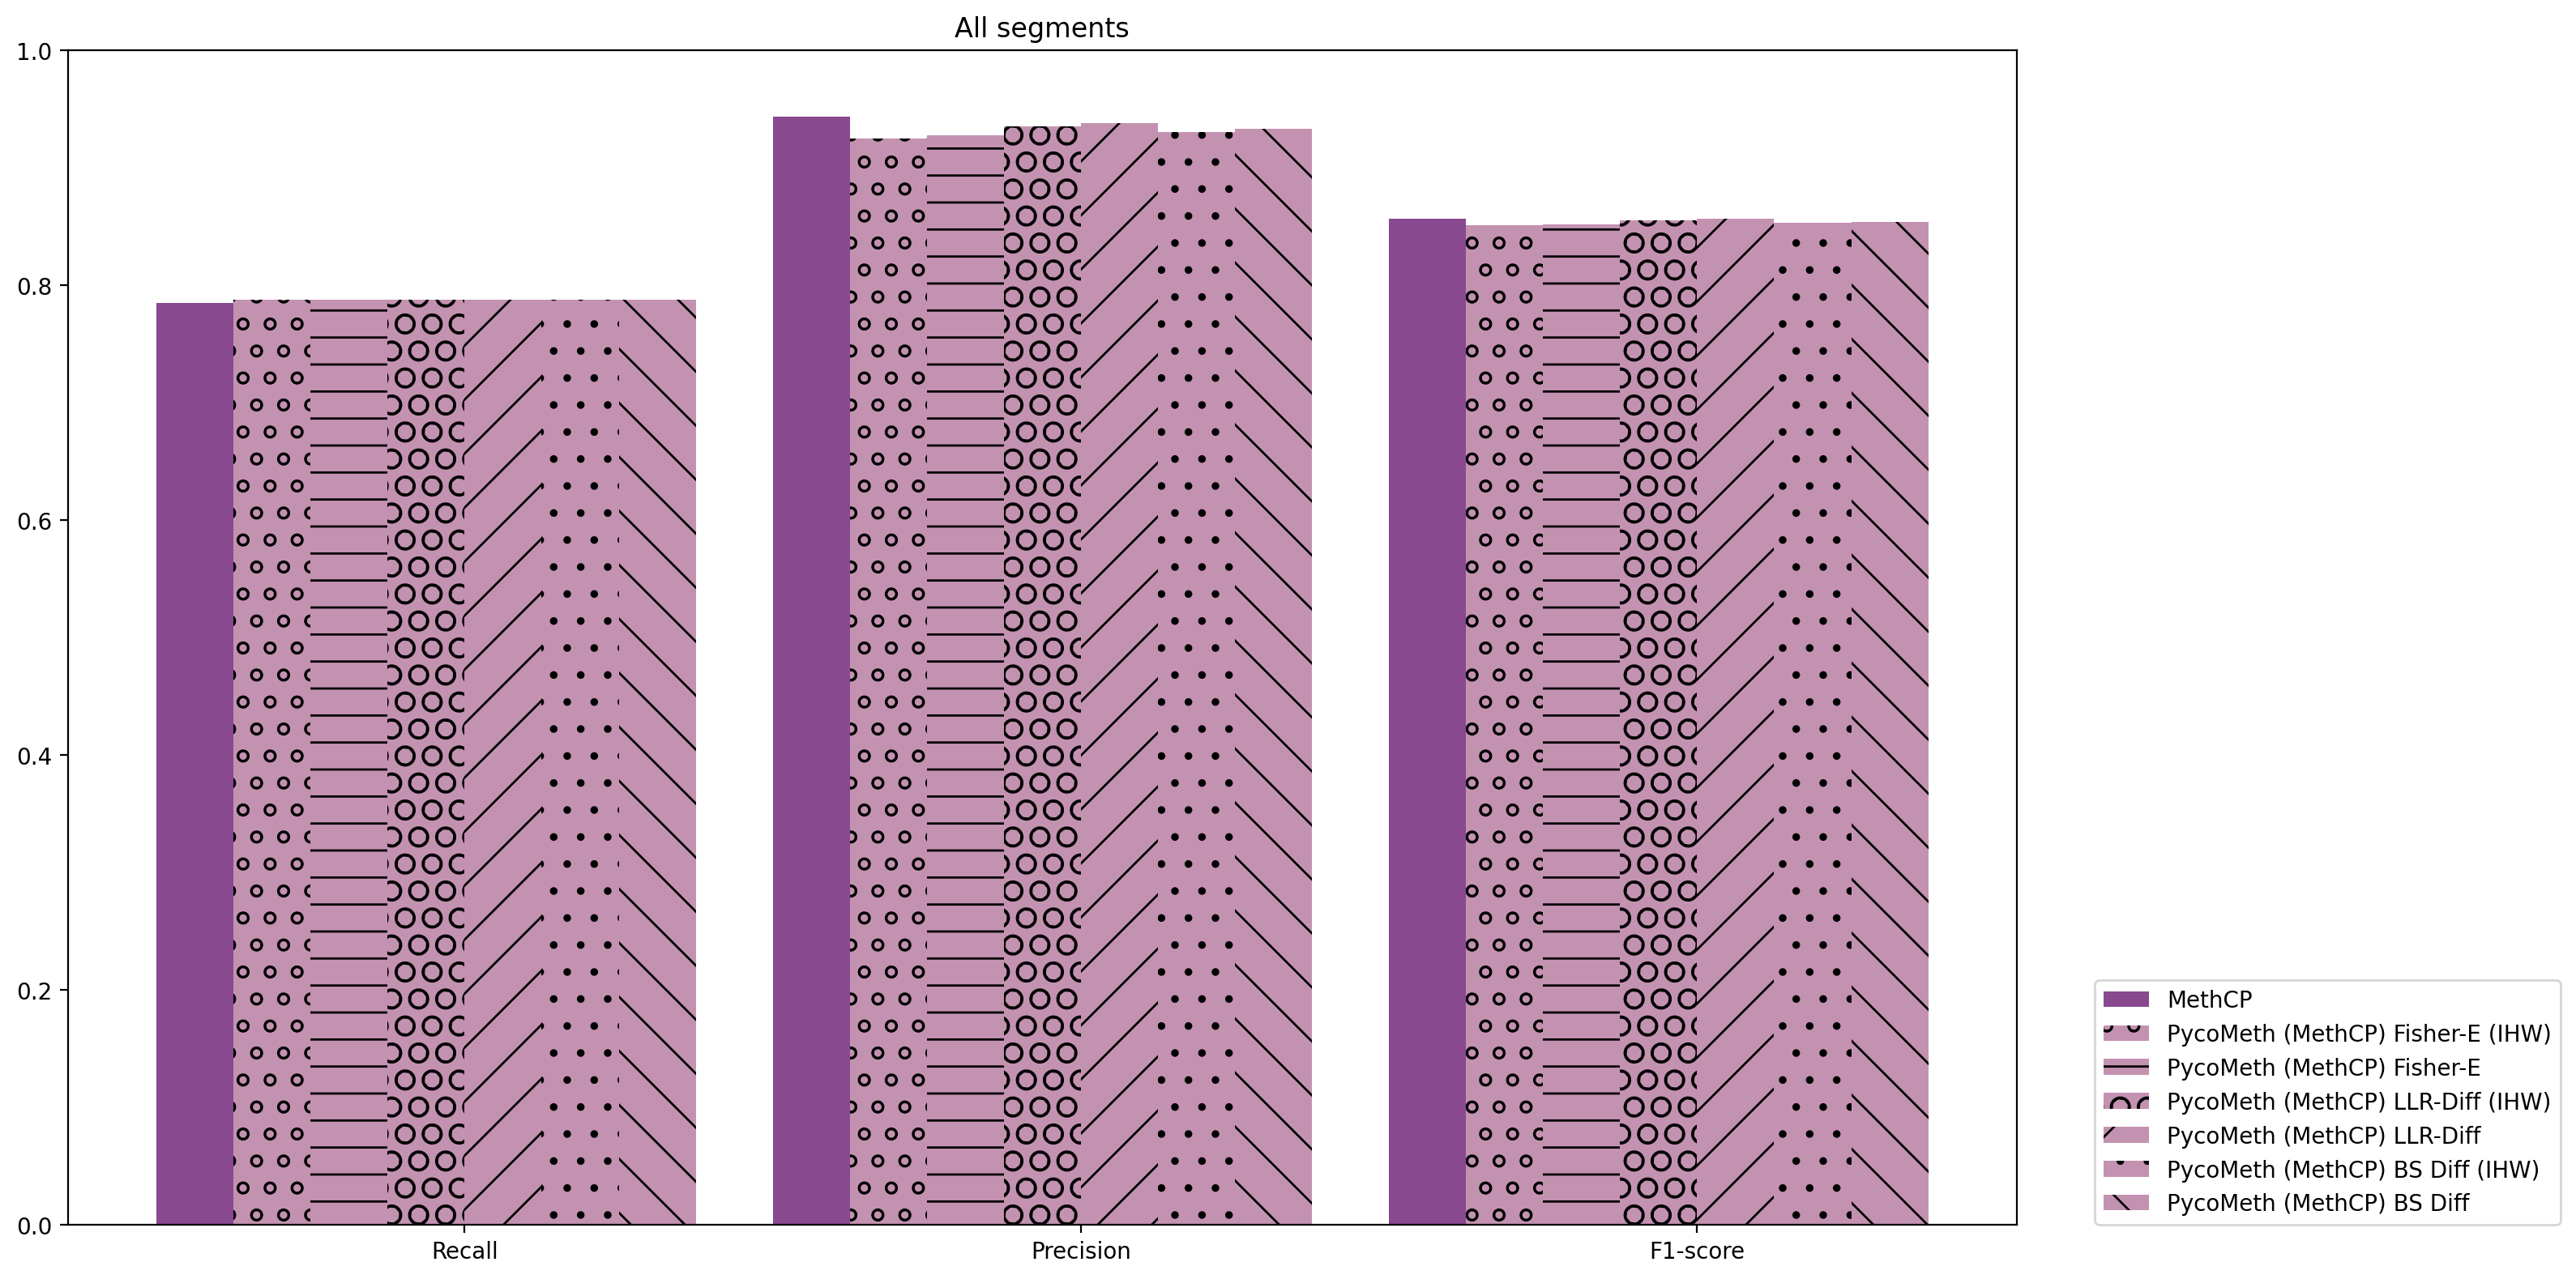

In [175]:
tools_include = ["MethCP", "PycoMeth (MethCP) Fisher-E (IHW)", "PycoMeth (MethCP) Fisher-E", "PycoMeth (MethCP) LLR-Diff (IHW)", "PycoMeth (MethCP) LLR-Diff", "PycoMeth (MethCP) BS Diff (IHW)", "PycoMeth (MethCP) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all", tool_colors=tool_colors)


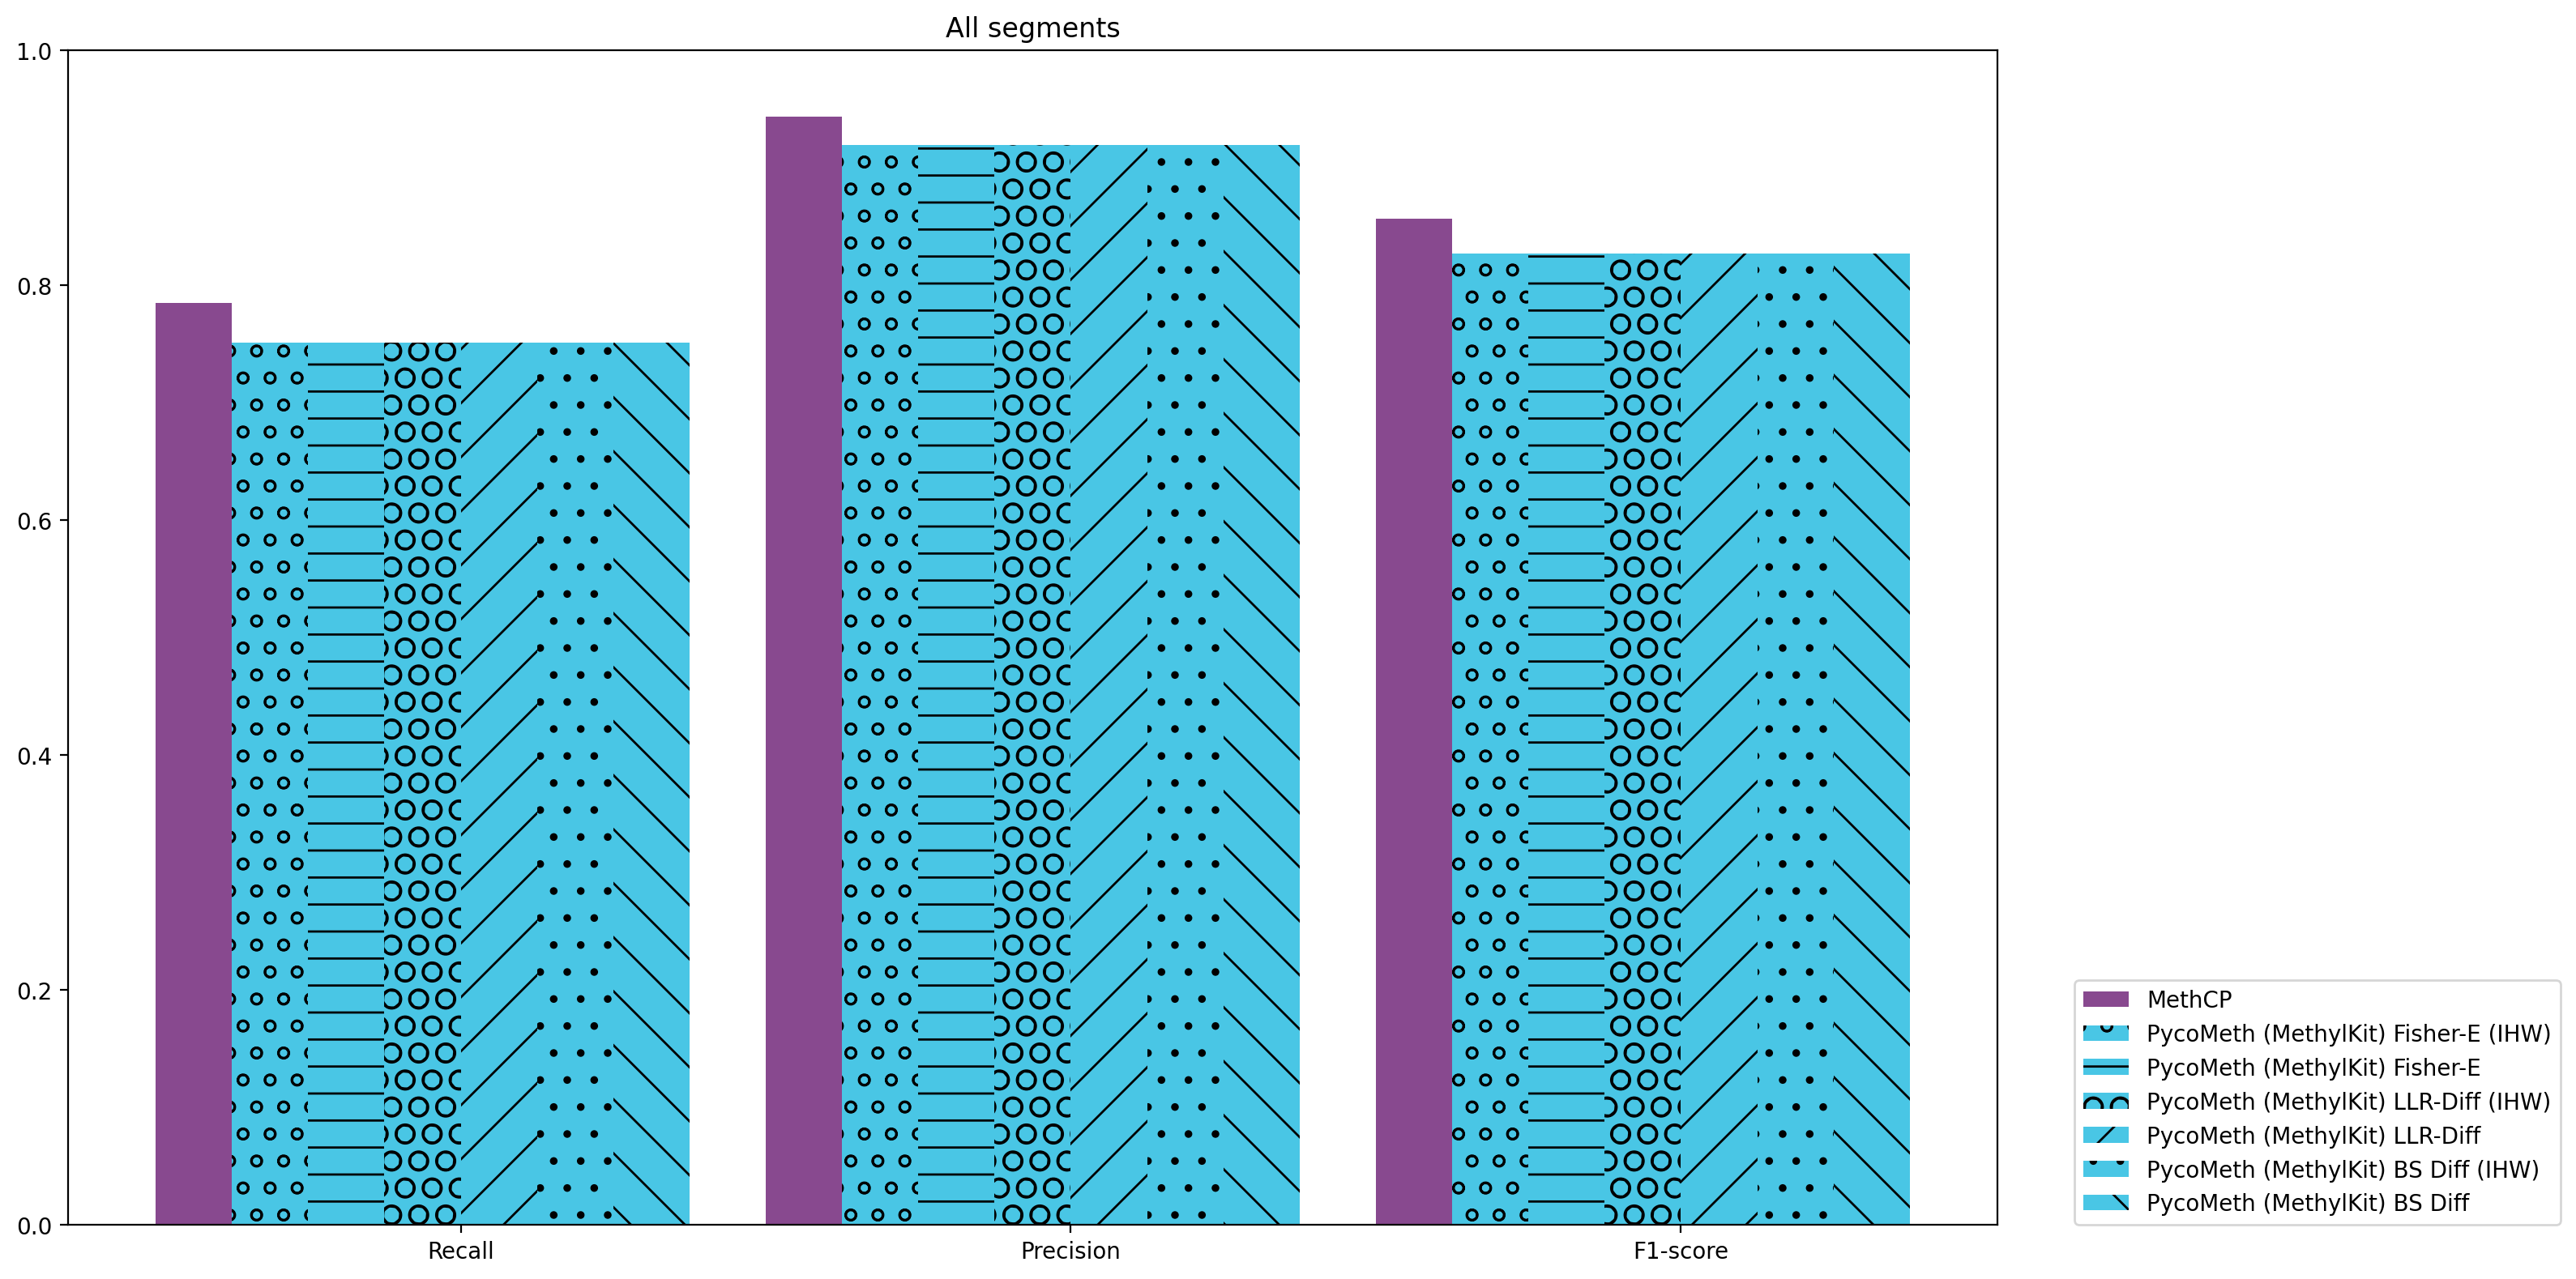

In [176]:
tools_include = ["MethCP", "PycoMeth (MethylKit) Fisher-E (IHW)", "PycoMeth (MethylKit) Fisher-E", "PycoMeth (MethylKit) LLR-Diff (IHW)", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethylKit) BS Diff (IHW)", "PycoMeth (MethylKit) BS Diff"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all", tool_colors=tool_colors)

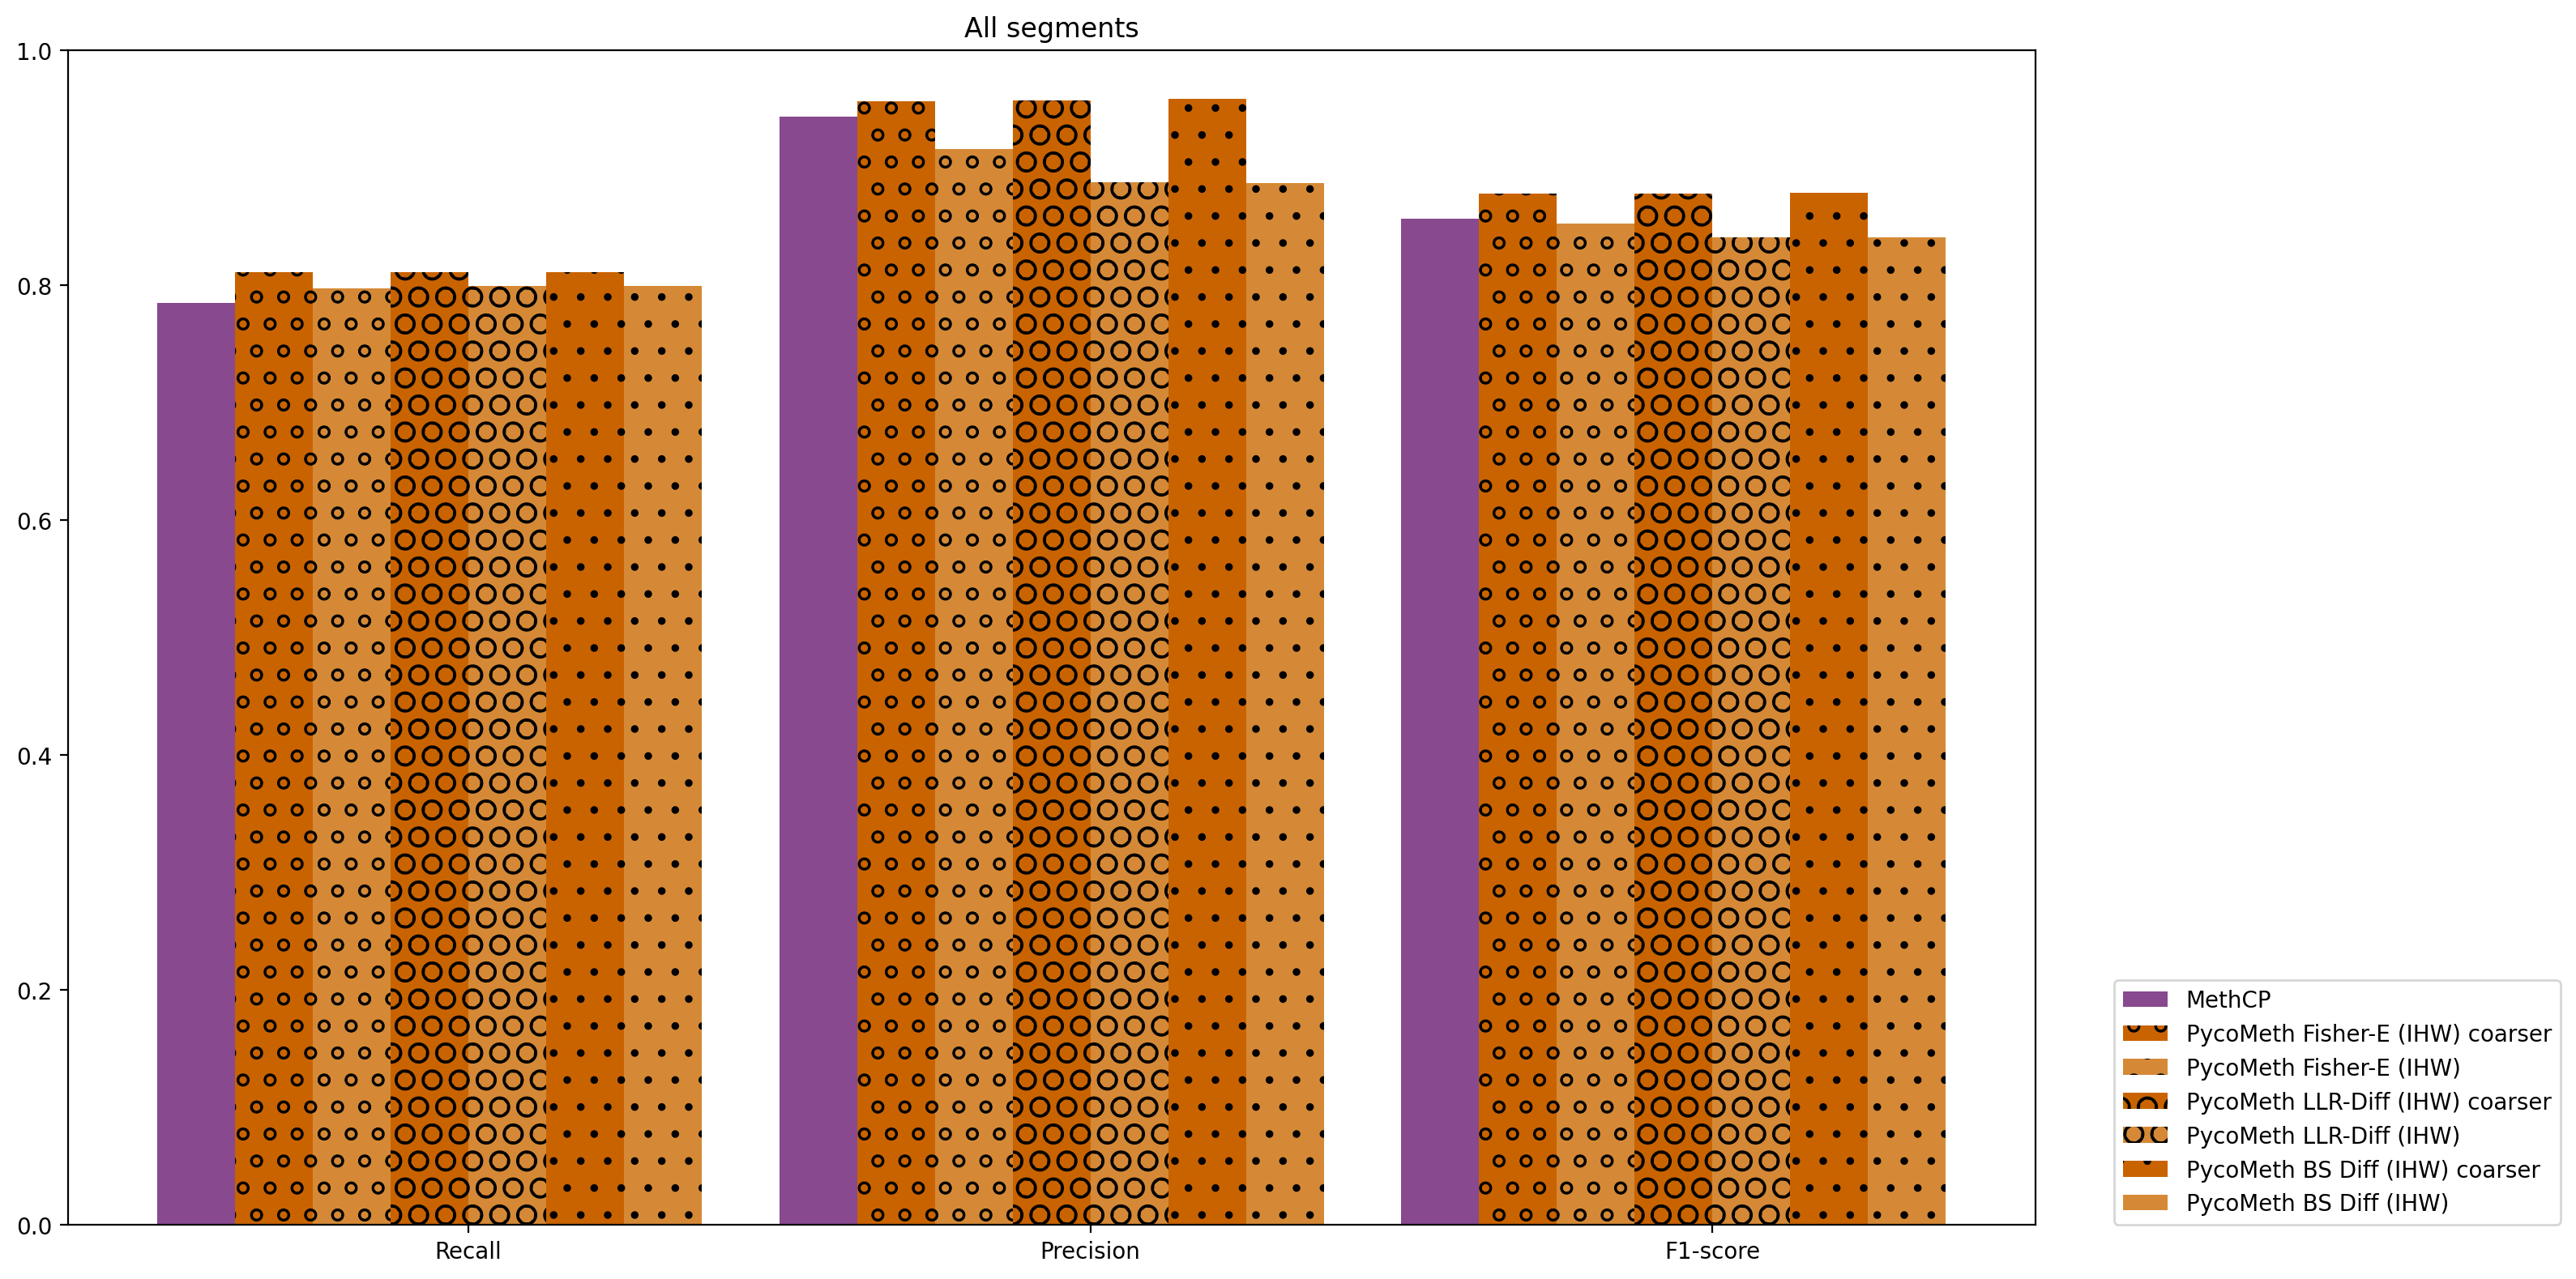

In [15]:
tools_include = ["MethCP", "PycoMeth Fisher-E (IHW) coarser", "PycoMeth Fisher-E (IHW)", "PycoMeth LLR-Diff (IHW) coarser", "PycoMeth LLR-Diff (IHW)", "PycoMeth BS Diff (IHW) coarser", "PycoMeth BS Diff (IHW)"]
tool_colors = {k:results.colors[k] for k in tools_include}
tool_patterns = {k:results.patterns.get(k,"") for k in tools_include}
gt = results.segments["GT"]
plot_measures(gt, "All segments", "roc_all", tool_colors=tool_colors)

In [ ]:
plot_measures(gt.loc[gt["segment_type"]==3].copy(), "Fuzzy segments", "roc_fuzzy", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]==2].copy(), "Methylated segments", "roc_methylated", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]==1].copy(), "Unmethylated segments", "roc_unmethylated", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["segment_type"]!=3].copy(), "All but fuzzy segments", "roc_notfuzzy", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.25)].copy(), ">=0.25 change", "roc_effect_size_ge0.25", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.5)].copy(), ">=0.5 change", "roc_effect_size_ge0.5", tool_colors=tool_colors, tool_patterns=tool_patterns)
plot_measures(gt.loc[gt["theta"].map(lambda x: abs(x) < 0.25)].copy(), "<0.25 change", "roc_effect_size_lt0.25", tool_colors=tool_colors, tool_patterns=tool_patterns)

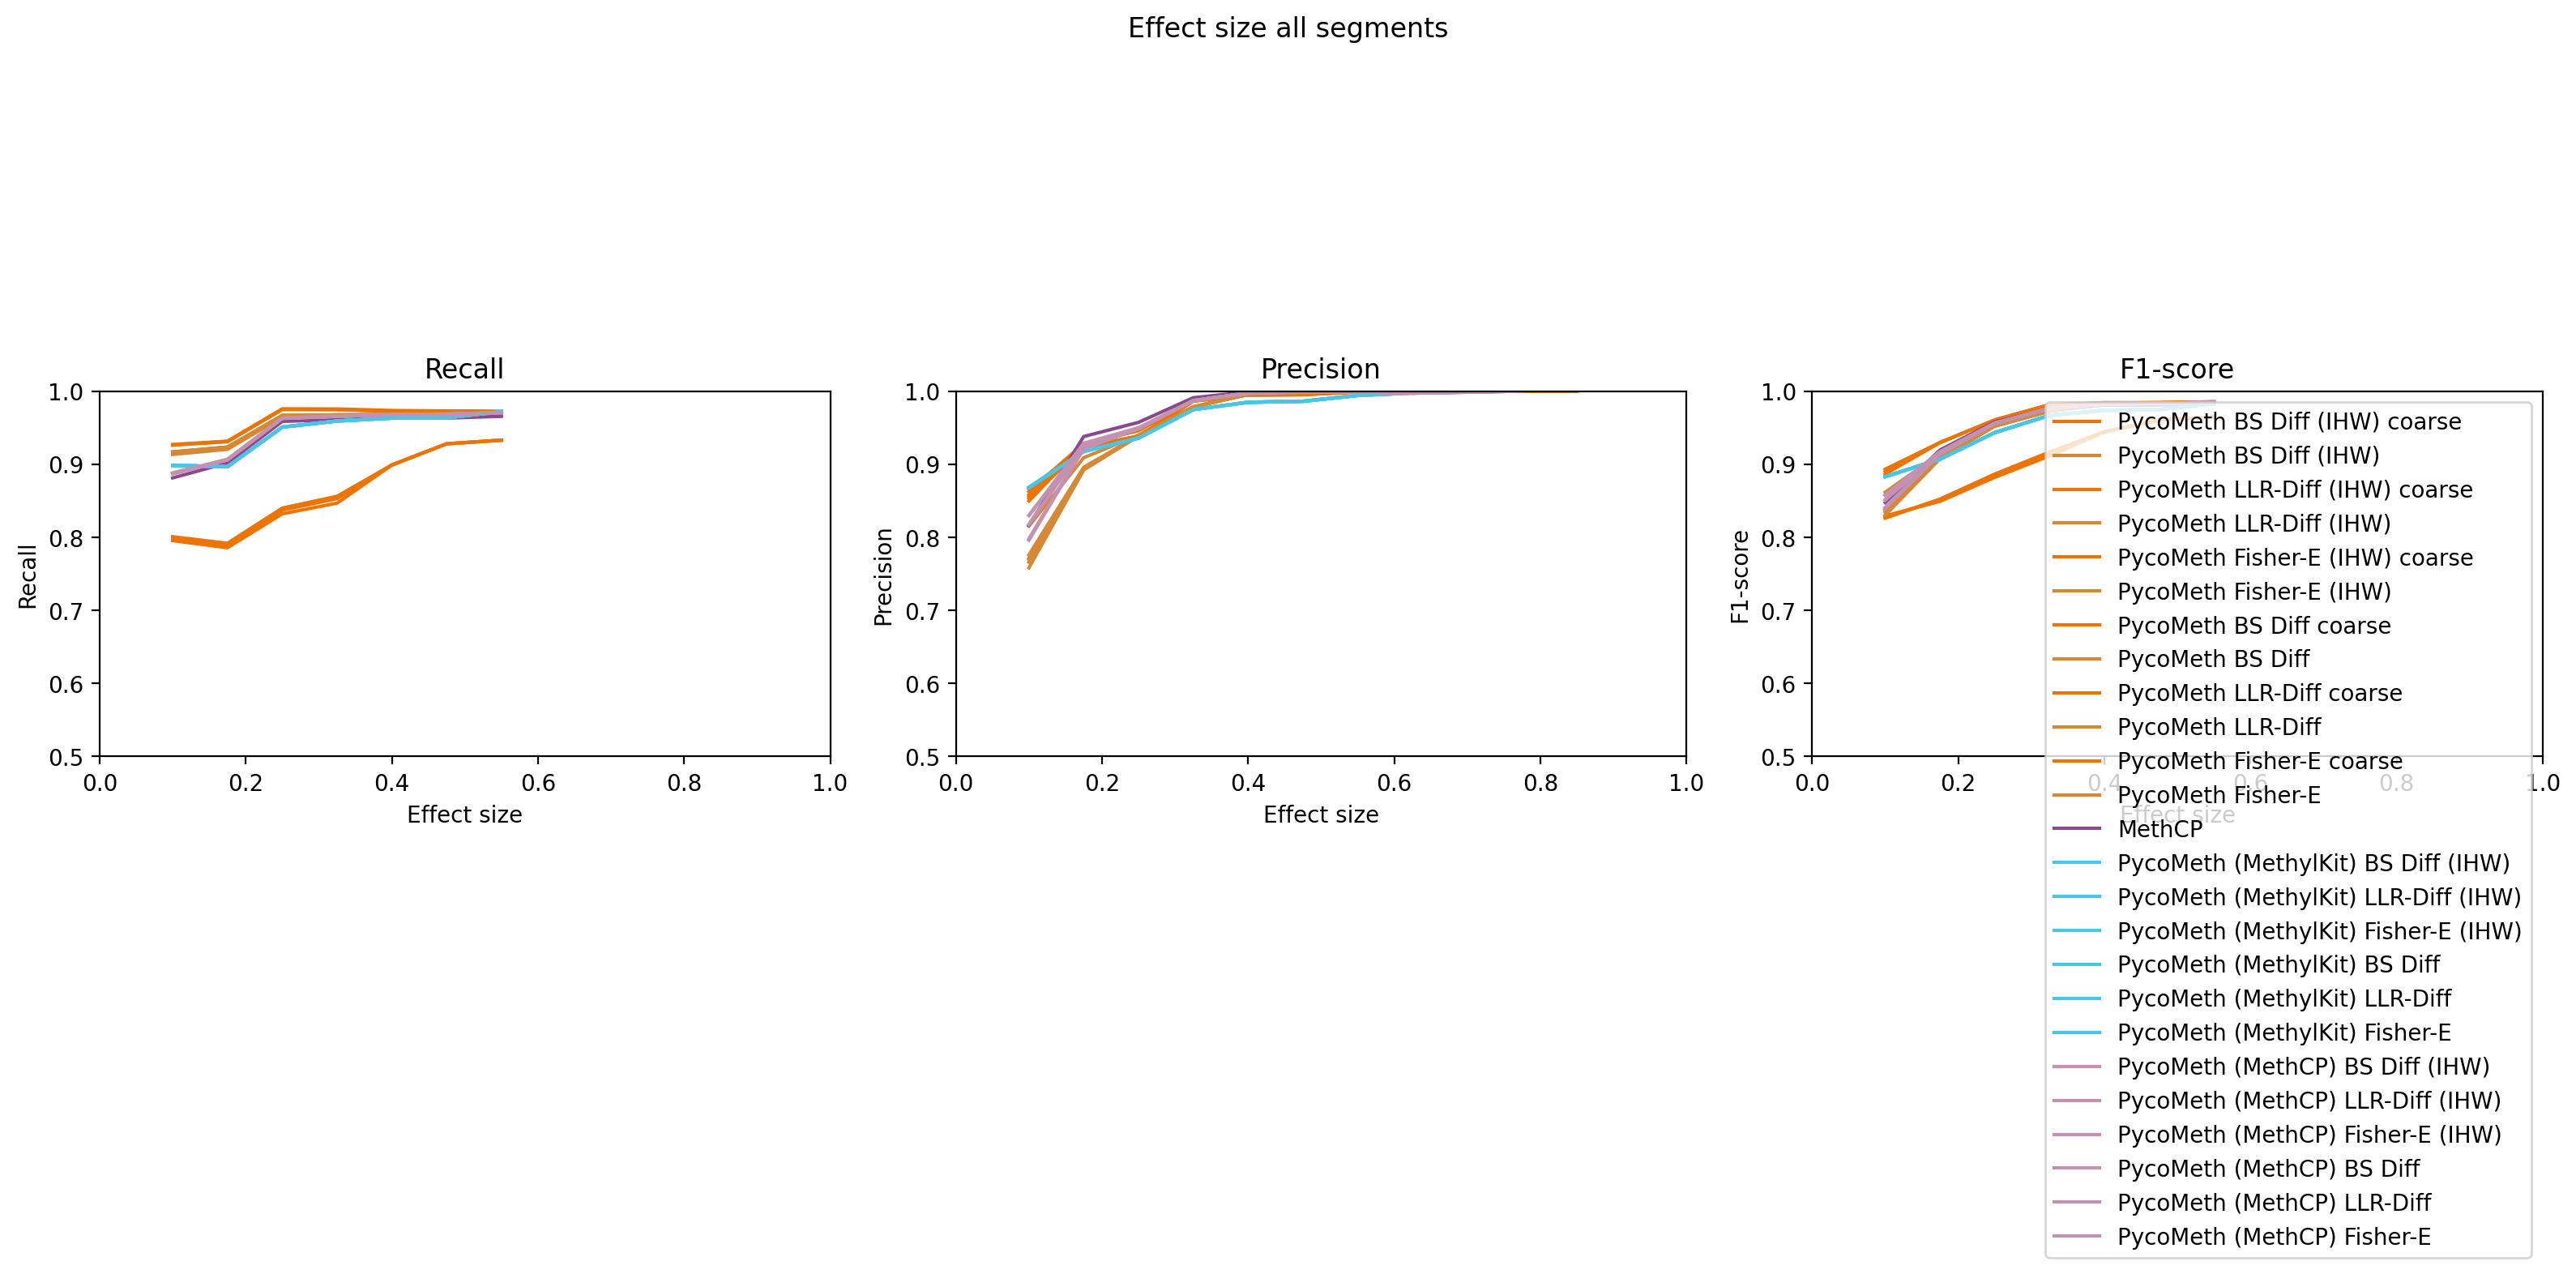

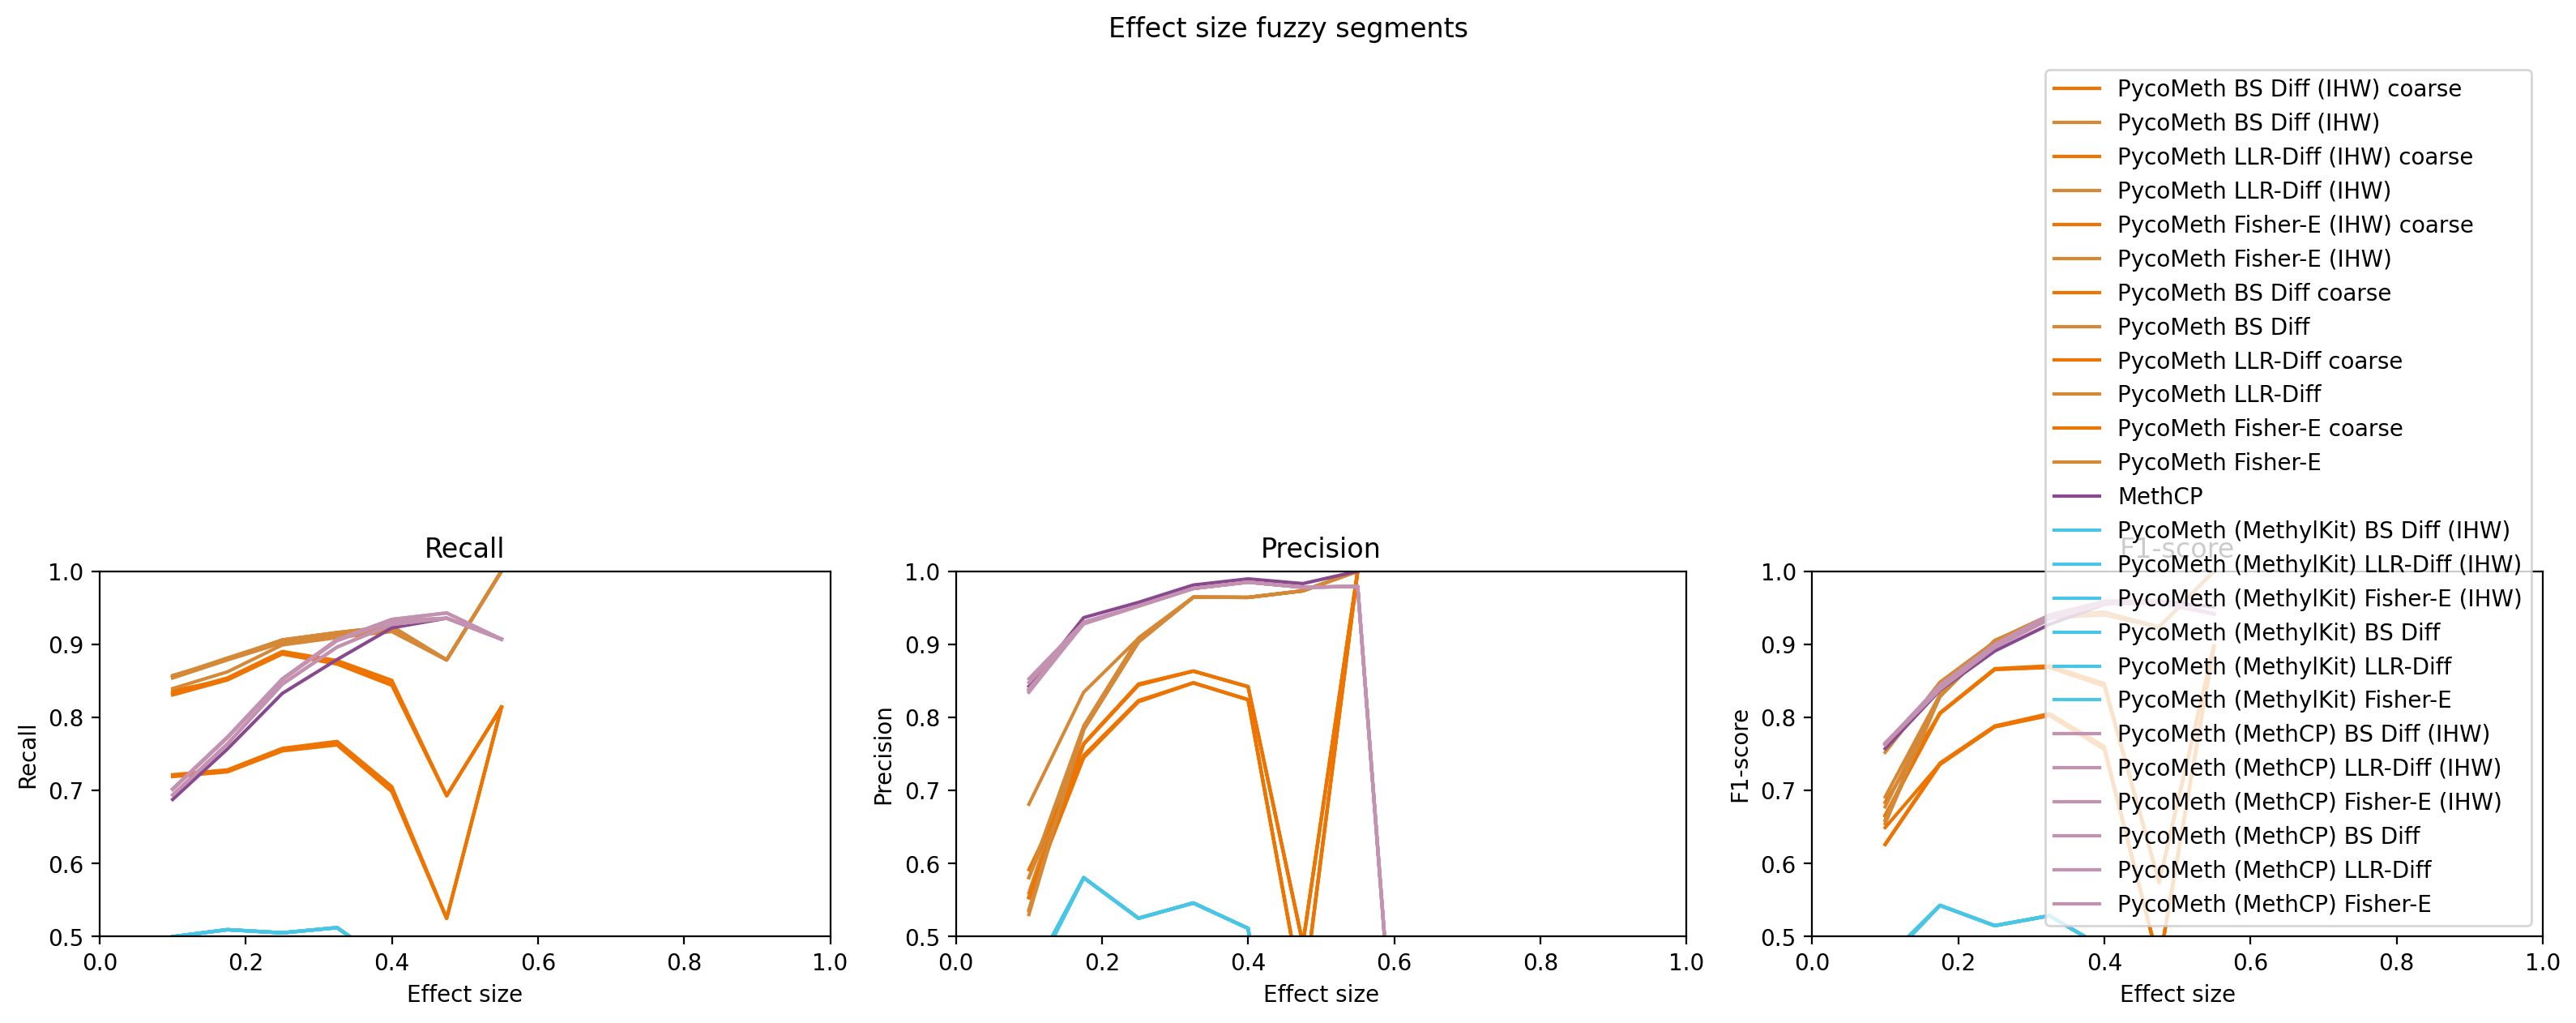

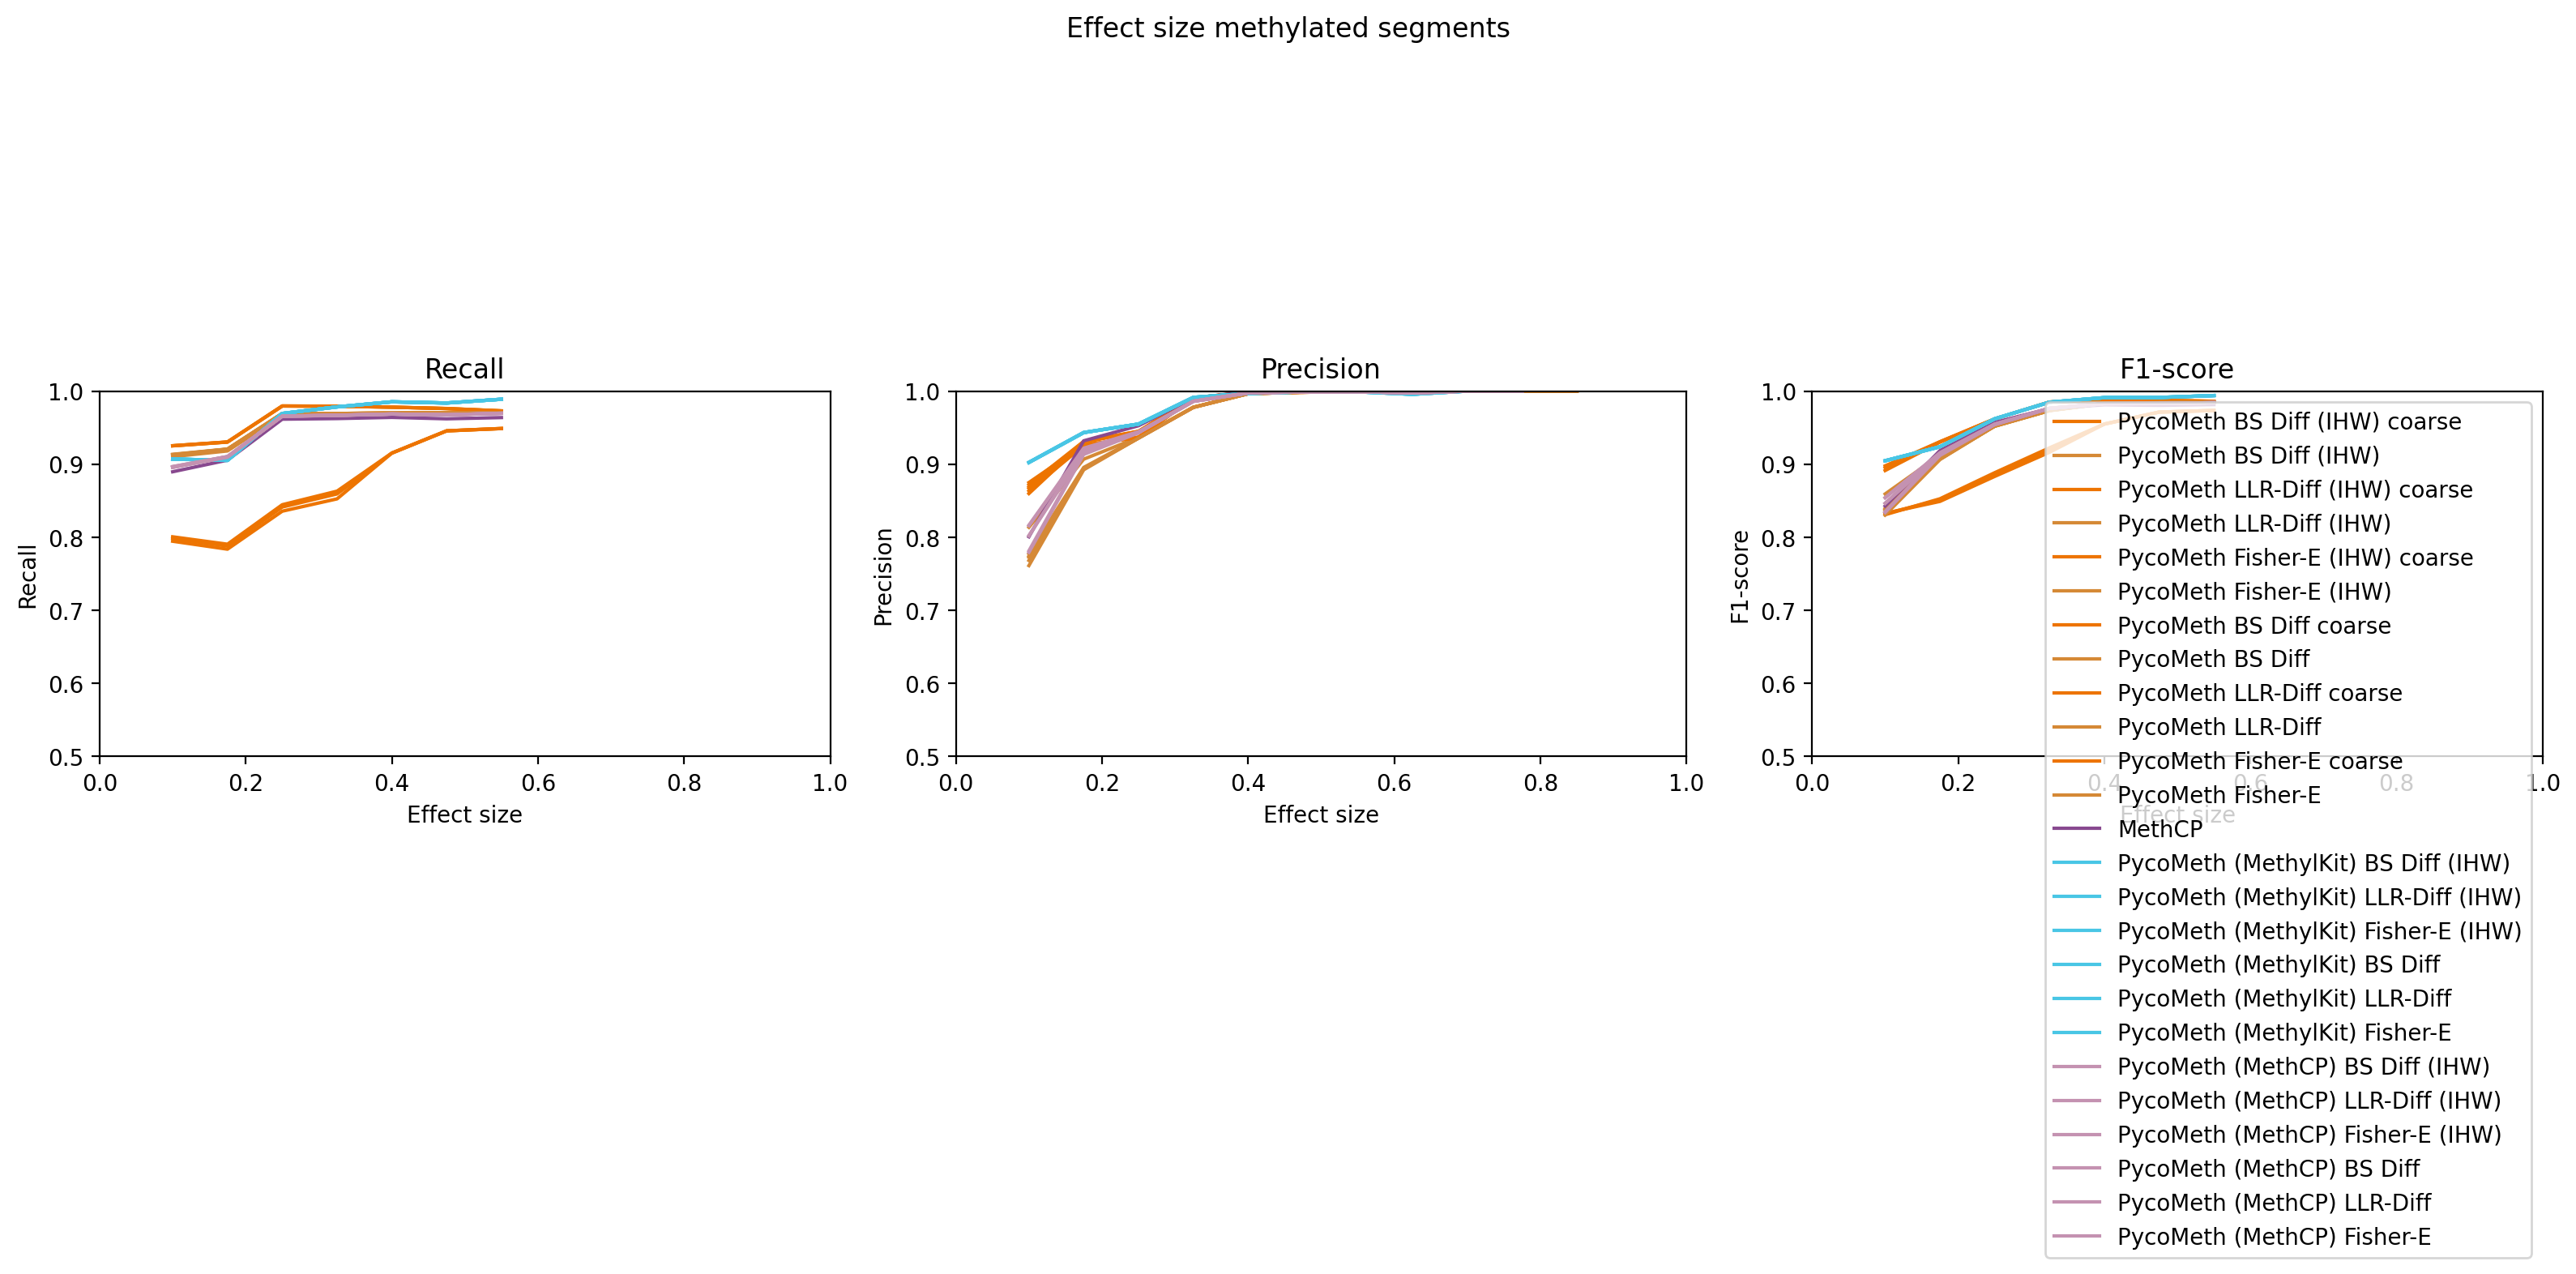

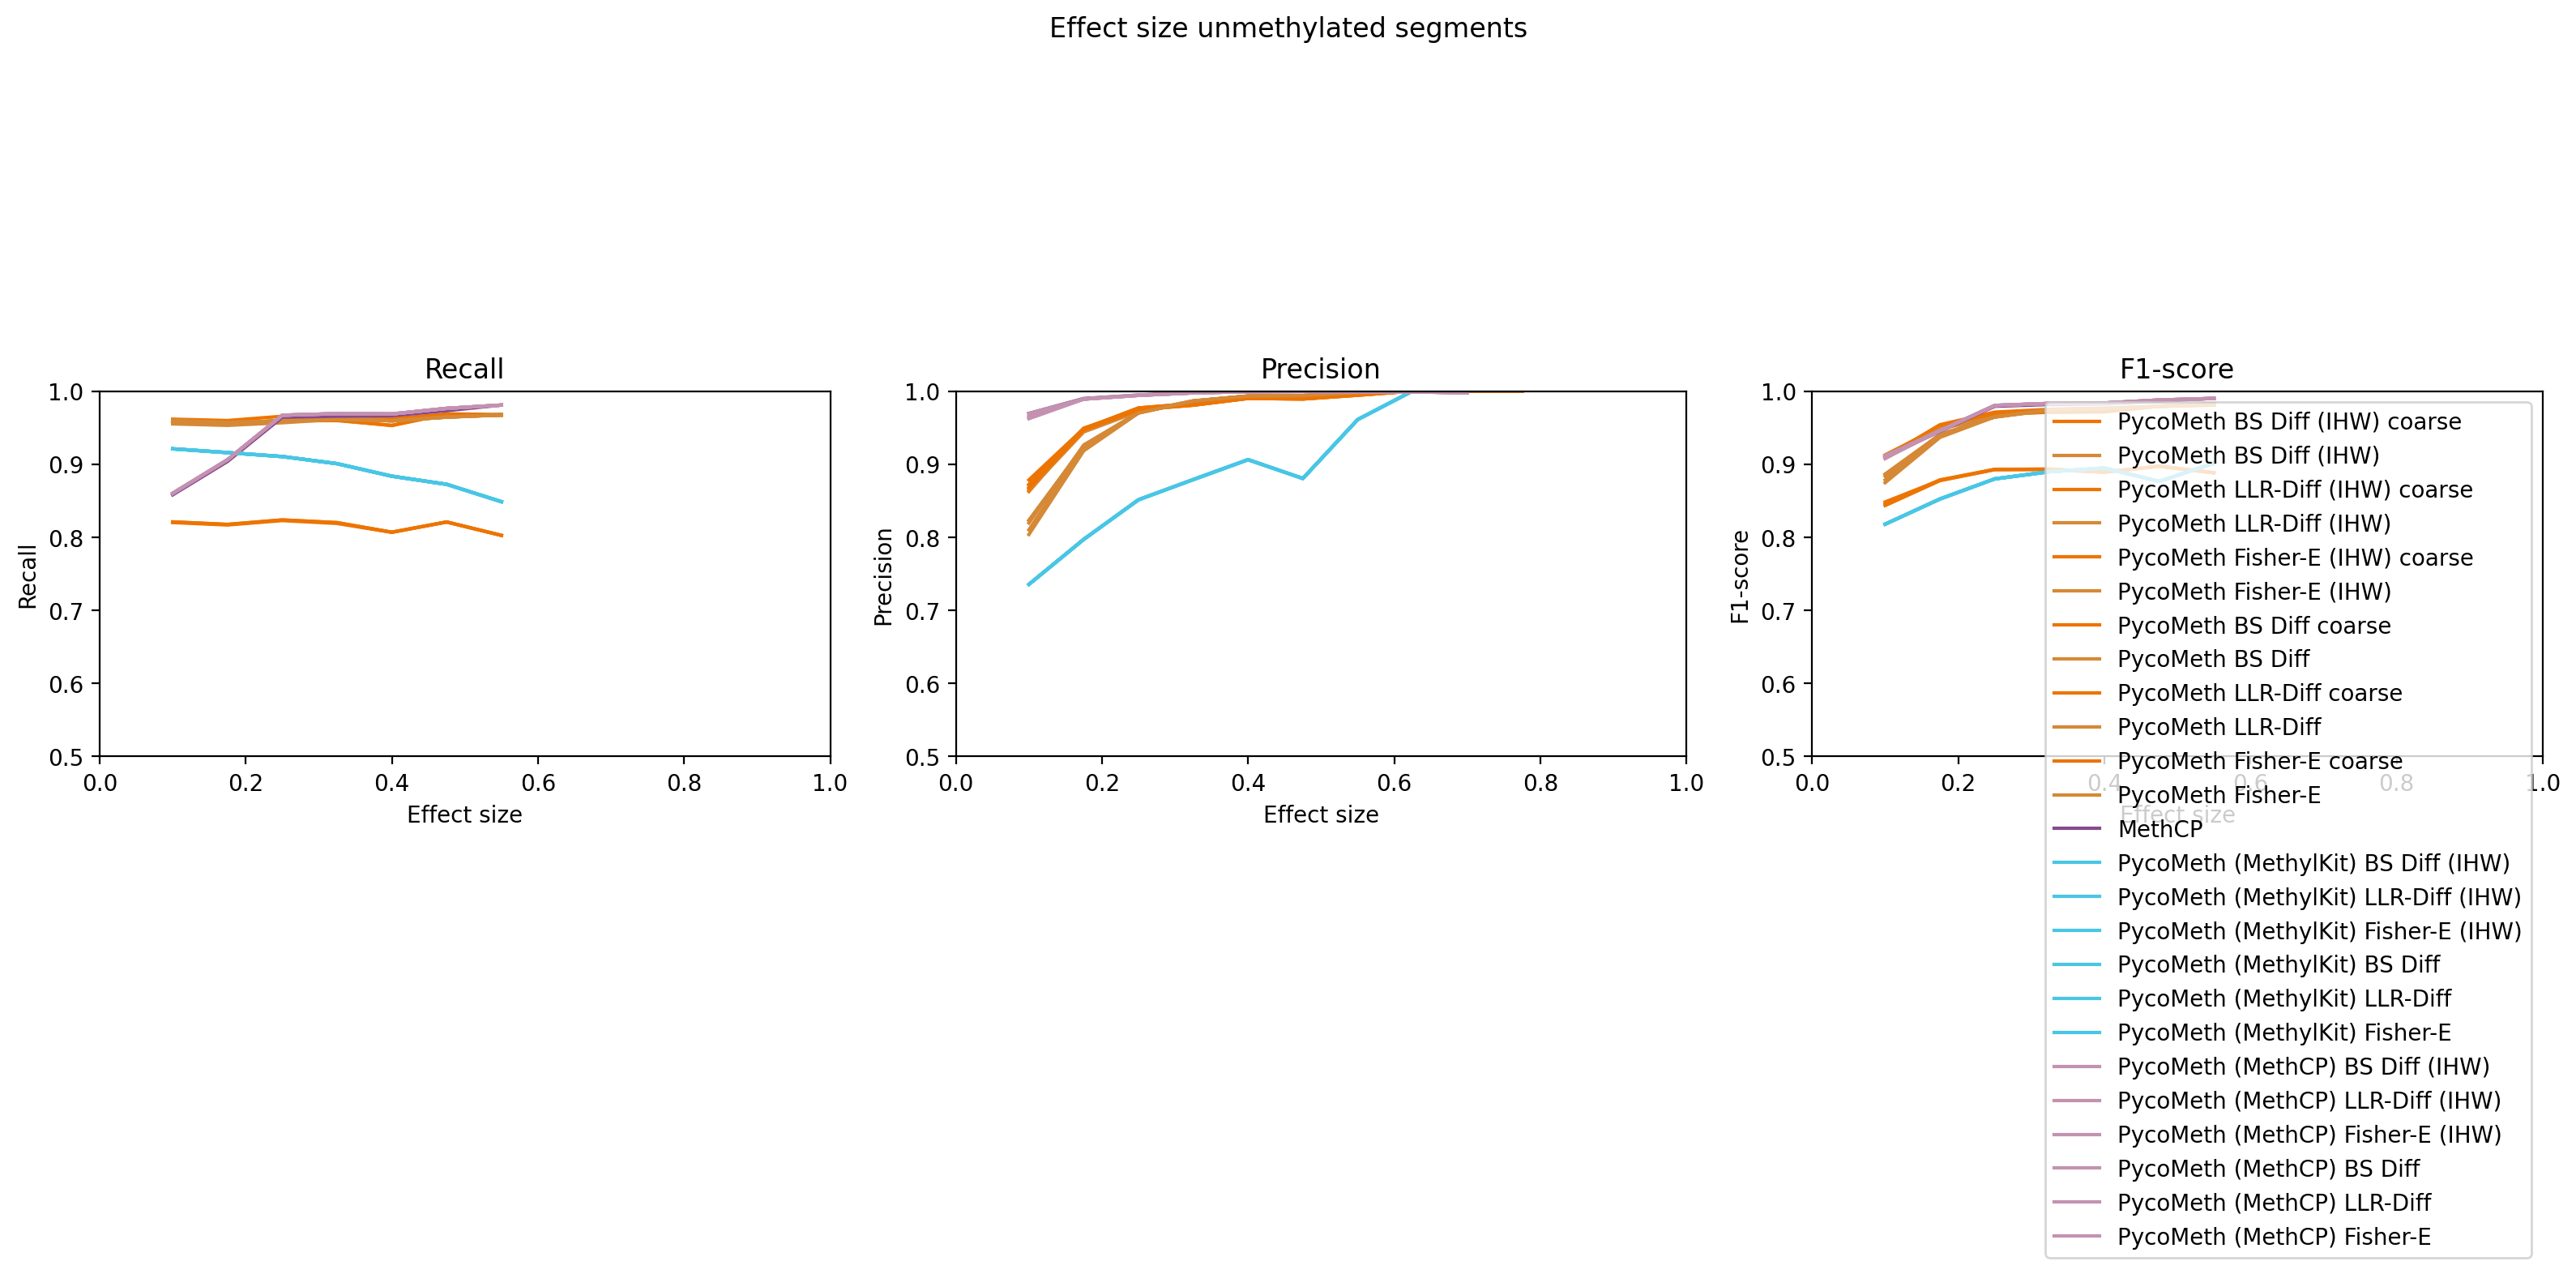

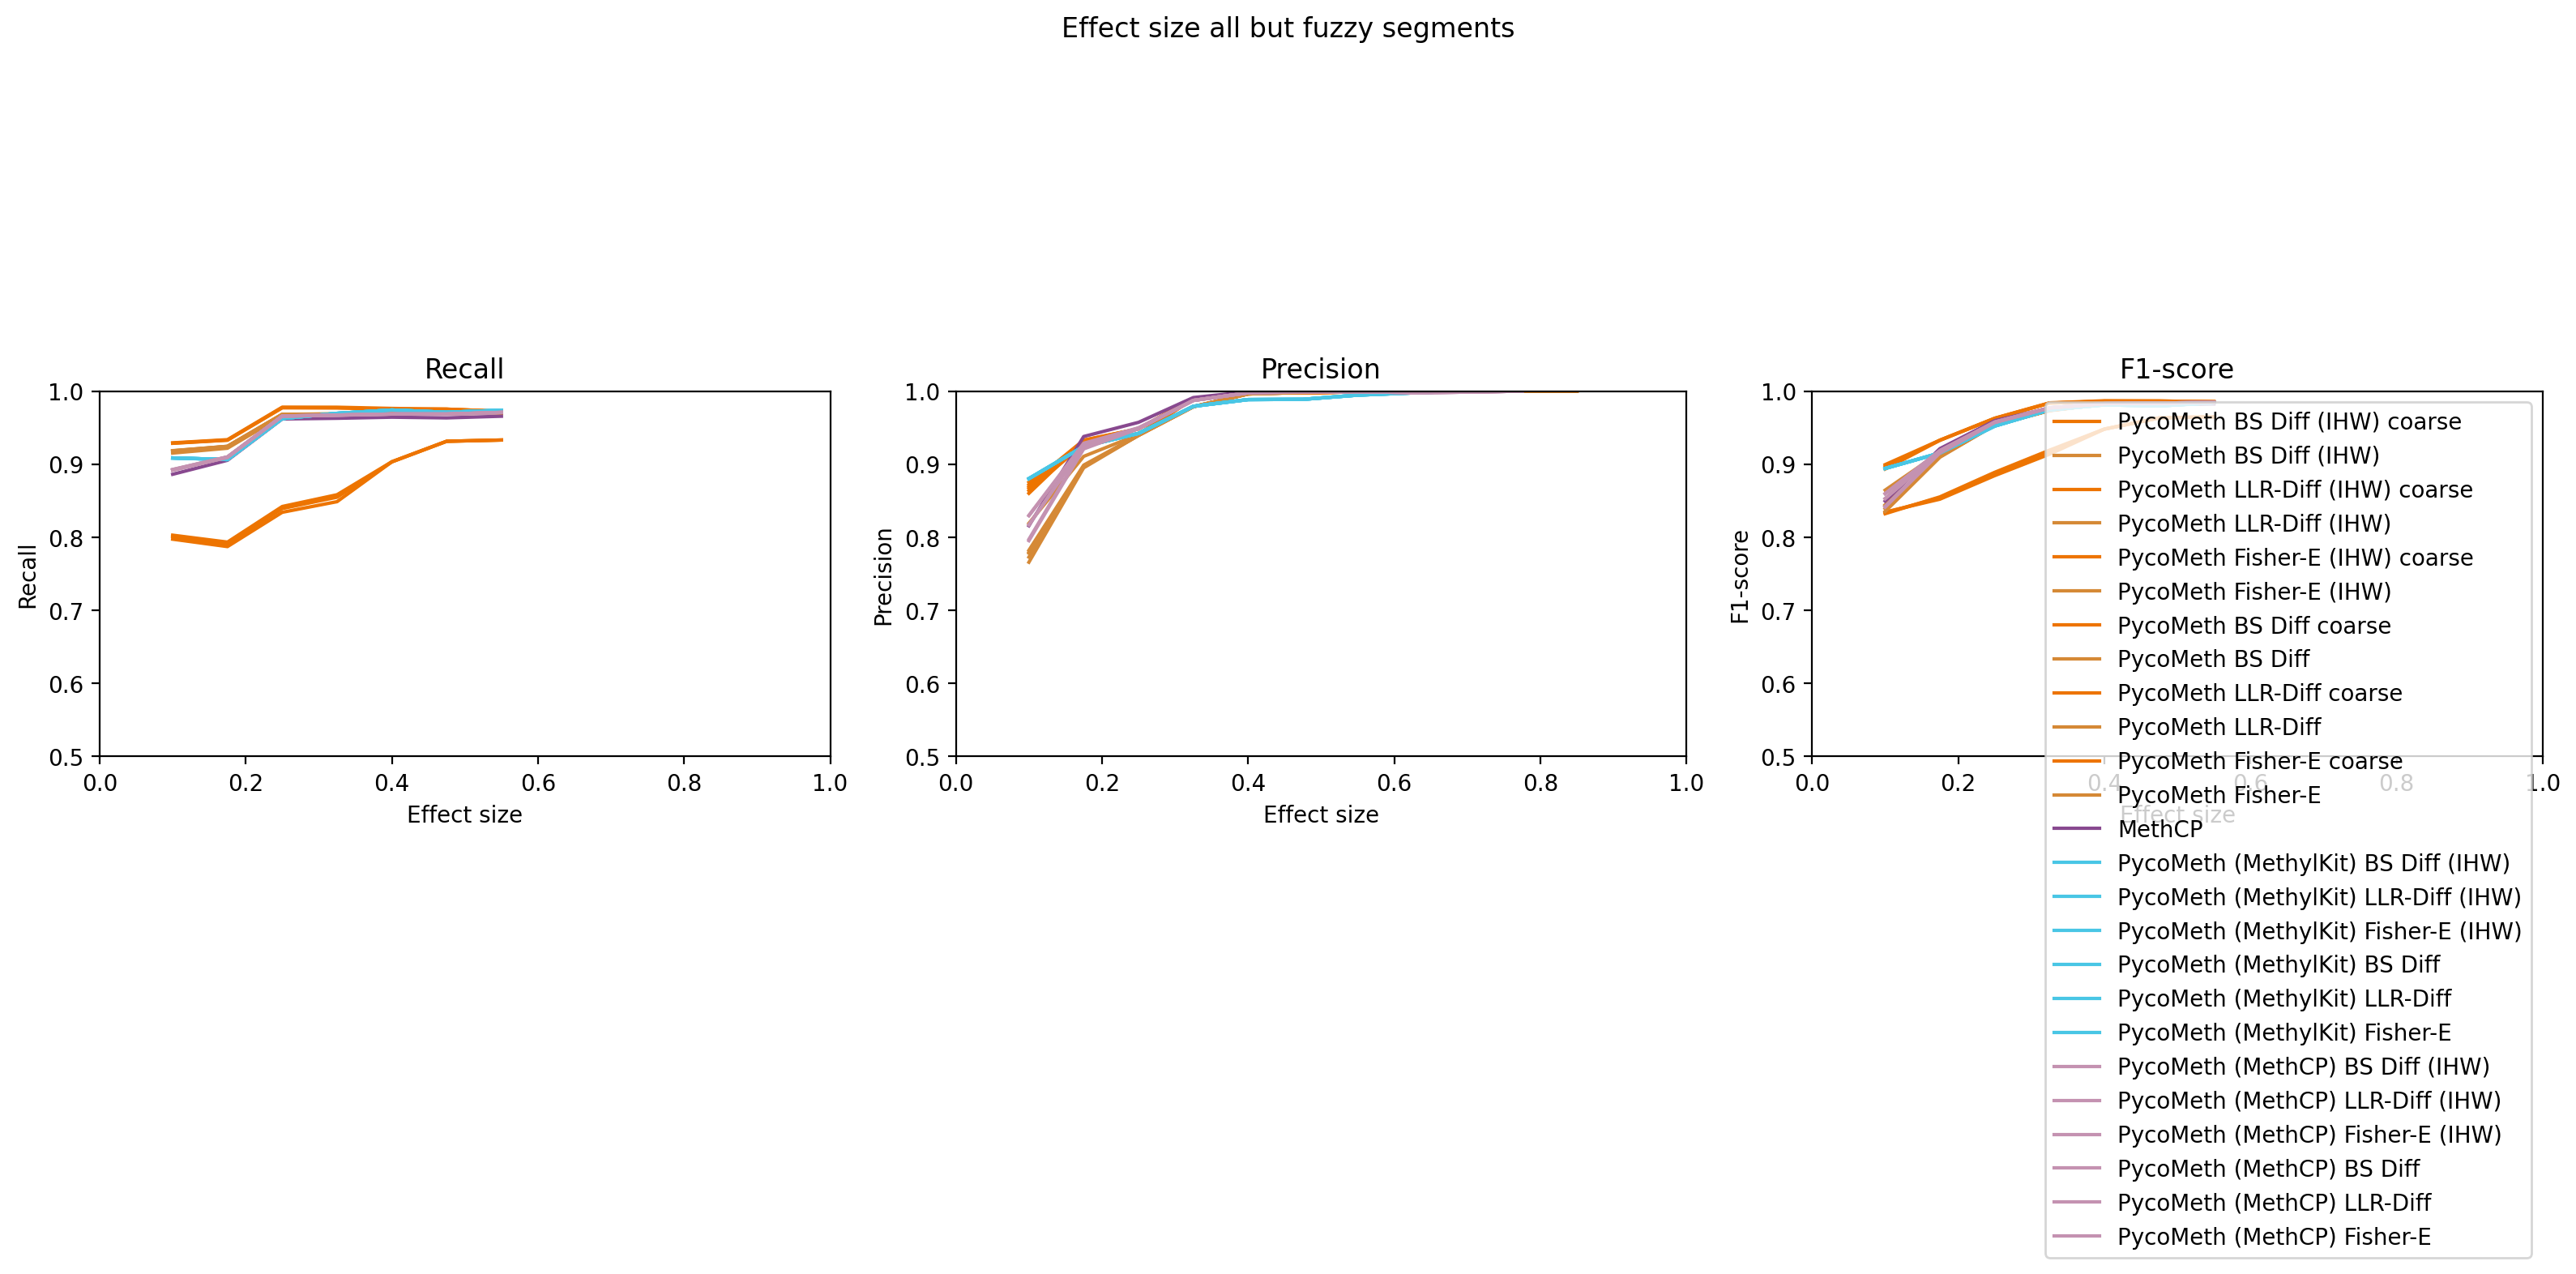

In [45]:
plot_roc_over_effect_size(gt, "Effect size all segments", "roc_effect_size_all")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==3].copy(), "Effect size fuzzy segments", "roc_fuzzy")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==2].copy(), "Effect size methylated segments", "roc_effect_size_methylated")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==1].copy(), "Effect size unmethylated segments", "roc_effect_size_unmethylated")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]!=3].copy(), "Effect size all but fuzzy segments", "roc_effect_size_notfuzzy")

In [40]:
rc = ResultComparer(results.segments)
rc.segments["GT"] = gt
rc.remove_cpgs_not_in_gt("GT")

In [73]:
d = pd.read_csv("/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methylkit/pycometh_methcomp/diffmet/diffmet_hyp_bs_diff_ihw_yes.tsv",
                sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
d = d.loc[d["adj_pvalue"]<0.05].copy()

In [80]:
len(unions(results.segments["PycoMeth (MethylKit) Fisher-E (IHW)"]["CpGs"]))

620637

In [81]:
len(unions(results.segments["PycoMeth (MethylKit) BS Diff (IHW)"]["CpGs"]))

218252

In [149]:
rc = ResultComparer(results.segments)
rc.segments["GT"] = gt
rc.remove_cpgs_not_in_gt("GT")

In [137]:
print(rc.compute_tpr("GT", "PycoMeth (MethylKit) Fisher-E (IHW)"))
print(rc.compute_tpr("GT", "PycoMeth (MethylKit) BS Diff (IHW)"))
print(rc.compute_fdr("GT", "PycoMeth (MethylKit) Fisher-E (IHW)", pval_threshold=0.05, theta_threshold=0.1, diffmet_threshold=0.1))
print(rc.compute_fdr("GT", "PycoMeth (MethylKit) BS Diff (IHW)", pval_threshold=0.05, theta_threshold=0.1, diffmet_threshold=0.1))

0.8374139951685814
0.8374139951685814
1.0
1.0


In [147]:
k = "PycoMeth (MethylKit) BS Diff (IHW)"
print(len(unions(rc.segments[k].loc[rc.segments[k]["diffmet"].map(lambda x: abs(x)>0)]["CpGs"])))
print(len(unions(rc.segments[k].loc[rc.segments[k]["diffmet"].map(lambda x: abs(x)>0.1)]["CpGs"])))
k = "PycoMeth (MethylKit) Fisher-E (IHW)"
print(len(unions(rc.segments[k].loc[rc.segments[k]["diffmet"].map(lambda x: abs(x)>0)]["CpGs"])))
print(len(unions(rc.segments[k].loc[rc.segments[k]["diffmet"].map(lambda x: abs(x)>0.1)]["CpGs"])))

217223
118320
619049
118394


In [178]:
set(results.segments["GT"]["theta"])

{-0.6,
 -0.55,
 -0.5,
 -0.45,
 -0.4,
 -0.35,
 -0.3,
 -0.25,
 -0.2,
 -0.15,
 0.0,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6}

In [179]:
results.segments["PycoMeth (MethylKit) Fisher-E (IHW)"].iloc[-1]

chrom                                                             1
start                                                     245330654
end                                                       246116114
n_samples                                                         2
pvalue                                                          0.0
adj_pvalue                                                      0.0
unique_cpg_pos                                                 8840
labels                                                        [1,2]
med_llr_list                  [2.5520580956775643,2.51255507458872]
difference                                  [-0.008433907289986498]
ihw_weight                                                 0.131978
avg_coverage                  [33.21070537536856,31.92267573696145]
comment                                          Significant pvalue
CpGs              {245628928, 245596161, 245858312, 245760009, 2...
diffmet                                         

In [180]:
results.segments["PycoMeth Fisher-E (IHW)"].iloc[-1]


chrom                                                             1
start                                                     249105932
end                                                       249119487
n_samples                                                         2
pvalue                                                     0.004709
adj_pvalue                                                 0.008359
unique_cpg_pos                                                  165
labels                                                        [1,2]
med_llr_list                 [2.891260019707287,2.6803659922678924]
difference                                   [-0.02256841124199549]
ihw_weight                                              1489.435547
avg_coverage                 [29.98170731707317,31.587878787878786]
comment                                          Significant pvalue
CpGs              {249107970, 249109512, 249114632, 249105932, 2...
diffmet                                         